In [37]:
import sys 
sys.path.append("../../")

# In[import libs]
import pandas as pd
import numpy as np
import os
import json
import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.ticker as ticker
from matplotlib.patches import Arc
from random import randint

from sklearn import metrics 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

from data_filters import scout_service as sct
from maths.pitch import dictCoordenadas36, draw_pitch, set_assists_coordinates
from maths.trig import calculate_distance_angles
#from plots import *
from calls import get_jogos_sde

from prettytable import PrettyTable
import math
import time

import gatomestre_sde as sde

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Retorna informações dos atletas
def get_atletas_sde(atleta_id):
    url = f'/atletas/{atleta_id}'
    try:
        response = sde._request_sde(url, False)
    except:
        url = f'/tecnicos/{atleta_id}'
        try:
            response = sde._request_sde(url, False)
        except:
            return None
    df = pd.DataFrame.from_dict(response).T
    df = sde.pivot_column(df, 'posicao')
    return df

In [3]:
def atualiza_informacoes_atleta(df):
    df_atletas = pd.DataFrame()
    for atleta_id in df['atleta_id'].unique():
        result = get_atletas_sde(int(atleta_id))
        df_atletas = pd.concat([df_atletas, result]).reset_index(drop=True)
    resultado = df.merge(df_atletas, how='left', on='atleta_id')
    return resultado

## Dataset

Dataset é coletado a partir de dados do Scout Service, referentes aos torneios no último biênio (2020/2021):

<code>
torneios = ['AmistososSelecao', 'Baiano', 'Brasileiro', 'BrasileiroB', 'BrasileiroFeminino', 'Carioca', 'CopaAmerica', 
            'CopaBrasil', 'CopaNordeste', 'CopaSPJunior', 'EliminatoriasCopaMundo', 'EuroCopa', 'Gaucho', 'Libertadores', 
            'Mineiro', 'OlimpiadasFutebolFeminino', 'OlimpiadasFutebolMasculino', 'Paulista', 'Pernambucano', 'PreLibertadores', 
            'RecopaSulAmericana', 'SulAmericana', 'SuperCopaBrasil']</code>

In [4]:
# In[Running]
raw = pd.read_csv('database/2023/scout_service/events/Eventos_All.gz',compression='gzip', low_memory=False)
#df.isnull().sum()
# lidar com Nan
raw = raw.fillna(0)
# # limpar colunas
del raw['index']
#del raw['Unnamed: 0']
# dados que precisam ser type <int>
raw = raw.astype({'PosicaoLance': 'int32', 'TempoPartida': 'int32', 'Jogador_Posicao': 'int32', 'atleta_id': 'int32', 'Rodada': 'int32','Codigo':'int32', 'clube_id':'int32','oponente_id':'int32'})
# eliminar lances inexistentes no dataframe
raw = raw[raw['PosicaoLance']!=-1]
raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2083723 entries, 0 to 2092461
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Codigo                 int32  
 1   Lance                  object 
 2   Nome                   object 
 3   Ocorrencia             object 
 4   PosicaoLance           int32  
 5   TempoPartida           int32  
 6   TimestampStr           object 
 7   atleta_id              int32  
 8   apelido                object 
 9   sigla                  object 
 10  Jogador_Posicao        int32  
 11  Partida_CodigoExterno  float64
 12  tempo                  object 
 13  tempo_2                object 
 14  clube_id               int32  
 15  Codigo_SCT             float64
 16  Partida_CodigoInterno  float64
 17  Rodada                 int32  
 18  Torneio                object 
 19  Edicao                 float64
 20  oponente_id            int32  
 21  home_dummy             float64
dtypes: float64(5), int

In [5]:
raw.head(3)

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,tempo,tempo_2,clube_id,Codigo_SCT,Partida_CodigoInterno,Rodada,Torneio,Edicao,oponente_id,home_dummy
0,74,Passe,Completo,PT33M50S,14,2,2023-05-04T01:04:50,69034,Paulinho,MEC,...,33:50,01:04:50,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0
1,74,Passe,Completo,PT34M47S,22,2,2023-05-04T01:04:46,69034,Paulinho,MEC,...,34:47,01:04:46,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0
2,74,Passe,Completo,PT35M31S,33,2,2023-05-04T01:04:44,69034,Paulinho,MEC,...,35:31,01:04:44,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0


In [6]:
# verificar se há finalizações na base na rodada atual
print(list(raw['Lance'].unique()))
print(list(raw['Nome'].unique()))


['Passe', 'Drible', 'Finalização', 'Arbitragem', 'Desarme', 'Não Encontrado', 'Finalização Cabeça', 'Bloqueio', 'Pênalti', 'Goleiro', 'Falta', 'Ações Genéricas']
['Completo', 'Drible Certo', 'Fora da Área Para Fora', 'Falta Recebida', 'Drible Errado', 'Desarme Incompleto', 'Perda de Posse de Bola', 'Incompleto', 'Dentro Área Fora', 'Impedimento', 'Cartão Amarelo', 'Falta Cometida', 'Rebatida', 'Desarme', 'Grande Área Para Fora', 'Dentro Área Bloqueado', 'Bloqueio', 'Penalti Cometido', 'Penalti Recebido', 'Gol', 'Goal Sofrido', 'Dentro Área Defendido', 'Defesa Normal', 'Defendida', 'Fora da Área Defendido', 'Defesa Difícil', 'Fora da Área Bloqueado', 'Decisivo', 'Dentro Área Gol', 'Grande Área Gol', 'Cartão Amarelo+Vermelho', 'Bloqueada', 'Fora', 'Fora da Área Trave', 'Grande Área Trave', 'Dentro Área Trave', 'Cartão Vermelho', 'Finalização Certa', 'Fora da Área Gol', 'Grande Área Bloqueado', 'Trave', 'Grande Área Defendido', 'Defesa de Pênalti', 'Finalização Errada', 'Gol Contra']


In [7]:
# padronizar colunas de acordo com pipeline cartola FC
raw = raw.rename(columns={'Jogador_Posicao':'posicao_id',
                         'Rodada':'rodada_id',
                         'oponente_id':'adversario_id',
                         'Partida_CodigoExterno': 'match_id',
                         'Partida_CodigoInterno':'match_id_sct'})

raw = raw.drop_duplicates(keep='last').reset_index(drop=True)
print(raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355272 entries, 0 to 355271
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Codigo         355272 non-null  int32  
 1   Lance          355272 non-null  object 
 2   Nome           355272 non-null  object 
 3   Ocorrencia     355272 non-null  object 
 4   PosicaoLance   355272 non-null  int32  
 5   TempoPartida   355272 non-null  int32  
 6   TimestampStr   355272 non-null  object 
 7   atleta_id      355272 non-null  int32  
 8   apelido        355272 non-null  object 
 9   sigla          355272 non-null  object 
 10  posicao_id     355272 non-null  int32  
 11  match_id       355272 non-null  float64
 12  tempo          355272 non-null  object 
 13  tempo_2        355272 non-null  object 
 14  clube_id       355272 non-null  int32  
 15  Codigo_SCT     355272 non-null  float64
 16  match_id_sct   355272 non-null  float64
 17  rodada_id      355272 non-nul

In [8]:
raw[raw['Nome']=='Decisivo']

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,tempo,tempo_2,clube_id,Codigo_SCT,match_id_sct,rodada_id,Torneio,Edicao,adversario_id,home_dummy
74,14,Passe,Decisivo,PT12M12S,32,1,2023-04-19T21:43:28,124268,Santiago Montiel,LAE,...,12:12,21:43:28,2498,14.0,15154.0,2,Libertadores,2023.0,0,0.0
1847,14,Passe,Decisivo,PT22M48S,25,1,2023-04-04T23:23:57,111428,Cándido,LAE,...,22:48,23:23:57,2400,14.0,15169.0,1,Libertadores,2023.0,0,0.0
2042,14,Passe,Decisivo,PT8M36S,29,1,2023-05-04T01:13:26,87354,Villalba,ATA,...,08:36,01:13:26,2458,14.0,15180.0,1,Libertadores,2023.0,0,0.0
2532,14,Passe,Decisivo,PT9M38S,29,1,2023-05-04T21:10:36,87354,Villalba,ATA,...,09:38,21:10:36,2458,14.0,15148.0,3,Libertadores,2023.0,0,0.0
2629,14,Passe,Decisivo,PT19M34S,33,2,2023-05-03T22:26:18,109993,Vázquez,ATA,...,19:34,22:26:18,2409,14.0,15146.0,3,Libertadores,2023.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353448,14,Passe,Decisivo,PT30M13S,34,1,2023-08-20T16:32:25,116034,Victor Hugo,MEC,...,30:13,16:32:25,262,14.0,15761.0,20,Brasileiro,2023.0,294,0.0
353676,14,Passe,Decisivo,PT1M,25,2,2023-08-20T17:06:58,104811,Sebastián Gómez,VOL,...,01:00,17:06:58,294,14.0,15761.0,20,Brasileiro,2023.0,262,1.0
354220,14,Passe,Decisivo,PT48M35S,29,2,2023-08-20T17:54:32,82627,Luiz Araújo,ATA,...,48:35,17:54:32,262,14.0,15761.0,20,Brasileiro,2023.0,294,0.0
354634,14,Passe,Decisivo,PT38M44S,13,1,2023-08-21T20:39:21,102928,Canobbio,ATA,...,38:44,20:39:21,293,14.0,15759.0,20,Brasileiro,2023.0,290,0.0


### Find Assists 

(Estudo feito para comparar com assistencias anotadas como passes de 'Nome' == 'decisivos')


In our dataframe: 

The column 'Lance' refers an event, and the column 'Nome' refers to each 'Lance' conclusion, in the same row.

Now, we want to detect all cases where:
 
'Lance' == 'Passe' from a first player was followed by a second 'Lance' == 'Finalização', or 'Lance' == 'Finalização Cabeça', from a second player, which resulted, either one, in a goal, that is, where 'Nome' has values either ['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol'], in the same row. 

When the first 'Passe' from first player, ended up resulting in a 'Finalizaçao'or 'FIinalização Cabeça' from the second player, resulting in one of those 'Nome' targets of the second player, it was an 'Assist', and must be tagged accordingly, with a 1, on a new colum 'Assist', which must be created, else 0. 

Important: 

1) subsequent event MUST belong to another 'atleta_id'  

2) subsequent event must be the closest event by timestamp from the first.

In [9]:
# def insert_assists_to_dataset(df):
#     # Sort by Timestamp
#     df_sorted = df.sort_values(by='TimestampStr').copy()
#     # Create columns for next event details
#     df_sorted['Next_Lance'] = df_sorted['Lance'].shift(-1)
#     df_sorted['Next_Nome'] = df_sorted['Nome'].shift(-1)
#     df_sorted['Next_atleta_id'] = df_sorted['atleta_id'].shift(-1)

#     # Initialize the 'Assist' column
#     df_sorted['Assist'] = 0

#     # Set the conditions for an assist
#     conditions = (
#         (df_sorted['Lance'] == 'Passe') &
#         (df_sorted['Next_Lance'].isin(['Finalização', 'Finalização Cabeça'])) &
#         (df_sorted['Next_Nome'].isin(['Gol', 'Dentro Área Gol', 'Grande Área Gol', 'Fora da Área Gol'])) &
#         (df_sorted['atleta_id'] != df_sorted['Next_atleta_id'])
#     )

#     df_sorted.loc[conditions, 'Assist'] = 1

#     # Drop temporary columns
#     df_sorted = df_sorted.drop(columns=['Next_Lance', 'Next_Nome', 'Next_atleta_id'])

#     return df_sorted


# Assistências e Pré-Assistências

- Selecionar assistências (passes decisivos)
- Filtrar passes completos anteriores a cada assistência

In [21]:
def selecionar_assistencias_e_pre_assistencias(df):
    assistencias = df.query("Nome == 'Decisivo'")
    # lista para armazenar pares de assistência e gol
    result_preassist = []
    for _, assist in assistencias.iterrows():
        # Recuperar os valores para filtrar a pré assistencia
        id_partida_preassist = assist['match_id']
        ocorrencia_preassist = assist['tempo']
        jogador_preassist = assist['atleta_id']
        tempo_preassist = assist['TempoPartida']
        # Filtrar raw com os valores
        preassist_correspondente = df.query("match_id == @id_partida_preassist and tempo < @ocorrencia_preassist and atleta_id != @jogador_preassist and TempoPartida == @tempo_preassist").tail(1)
        # Adicionar a lista caso exista pré-assistencia para aquela assistencia
        if preassist_correspondente['Nome'].values == 'Completo':
            preassist_correspondente['Pre_Assistencia'] = 1
            preassist_correspondente['Assistencia'] = 0
            assist['Pre_Assistencia'] = 0
            assist['Assistencia'] = 1
            result_preassist.append(preassist_correspondente.iloc[0])
            result_preassist.append(assist)
    # DF com as assistências e pré assistencias relacionados
    df_preassist = pd.DataFrame(result_preassist)
    merged = raw.merge(df_preassist[['Nome', 'TimestampStr', 'atleta_id', 'match_id', 'Pre_Assistencia', 'Assistencia']], 
                   on=['Nome', 'TimestampStr', 'atleta_id', 'match_id'], 
                   how='left')
    # Replace NaN values with 0
    merged['Pre_Assistencia'].fillna(0, inplace=True)
    merged['Assistencia'].fillna(0, inplace=True)
    # Convert to integer
    merged['Pre_Assistencia'] = merged['Pre_Assistencia'].astype(int)
    merged['Assistencia'] = merged['Assistencia'].astype(int)
    return merged

In [25]:
raw_preassist = selecionar_assistencias_e_pre_assistencias(raw)

In [26]:
raw_preassist

,Codigo,Lance,Nome,Ocorrencia,PosicaoLance,TempoPartida,TimestampStr,atleta_id,apelido,sigla,...,clube_id,Codigo_SCT,match_id_sct,rodada_id,Torneio,Edicao,adversario_id,home_dummy,Pre_Assistencia,Assistencia
0,74,Passe,Completo,PT33M50S,14,2,2023-05-04T01:04:50,69034,Paulinho,MEC,...,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0,0,0
1,74,Passe,Completo,PT34M47S,22,2,2023-05-04T01:04:46,69034,Paulinho,MEC,...,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0,0,0
2,74,Passe,Completo,PT35M31S,33,2,2023-05-04T01:04:44,69034,Paulinho,MEC,...,264,74.0,15176.0,1,Libertadores,2023.0,283,1.0,0,0
3,94,Drible,Drible Certo,PT36M56S,27,2,2023-05-04T01:04:38,69034,Paulinho,MEC,...,264,94.0,15176.0,1,Libertadores,2023.0,283,1.0,0,0
4,24,Finalização,Fora da Área Para Fora,PT36M57S,27,2,2023-05-04T01:04:37,69034,Paulinho,MEC,...,264,24.0,15176.0,1,Libertadores,2023.0,283,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355315,33,Arbitragem,Falta Cometida,PT49M44S,26,2,2023-08-21T21:55:20,102928,Canobbio,ATA,...,293,33.0,15759.0,20,Brasileiro,2023.0,290,0.0,0,0
355316,46,Arbitragem,Cartão Amarelo,PT49M51S,0,2,2023-08-21T21:55:26,102928,Canobbio,ATA,...,293,46.0,15759.0,20,Brasileiro,2023.0,290,0.0,0,0
355317,25,Passe,Incompleto,PT49M59S,11,2,2023-08-21T21:55:34,82453,Tadeu,GOL,...,290,25.0,15759.0,20,Brasileiro,2023.0,293,1.0,0,0
355318,74,Passe,Completo,PT50M2S,9,2,2023-08-21T21:55:37,101594,Hugo Moura,VOL,...,293,74.0,15759.0,20,Brasileiro,2023.0,290,0.0,0,0


## Transformação das Coordenadas
#### Recebemos do ScoutService os lances posicionados em apenas 36 quadrantes. Precisamos:
- Randomizar as coordenadas (x,y) dentro do quadrante para gerar variância 
- Calcular a distância de cada coordenada em relação ao gol
- Calcular o ângulo (degrees e radians) da coordenada em relação ao gol

In [27]:
# transformar coordenadas centralizadas nos 36 quadrantes em coordenadas (x,y) com variância randomizada
# filtragem por finalizações
df_assists_on_pitch = set_assists_coordinates(raw_preassist,'xA')
df_assists_on_pitch.to_csv('Assistencias.csv')
print(df_assists_on_pitch, df_assists_on_pitch.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220384 entries, 0 to 355319
Data columns (total 33 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Codigo                220384 non-null  int64  
 1   Lance                 220384 non-null  object 
 2   Nome                  220384 non-null  object 
 3   Ocorrencia            220384 non-null  object 
 4   PosicaoLance          220384 non-null  int64  
 5   TempoPartida          220384 non-null  int64  
 6   TimestampStr          220384 non-null  object 
 7   atleta_id             220384 non-null  int64  
 8   apelido               220384 non-null  object 
 9   sigla                 220384 non-null  object 
 10  posicao_id            220384 non-null  int64  
 11  match_id              220384 non-null  float64
 12  tempo                 220384 non-null  object 
 13  tempo_2               220384 non-null  object 
 14  clube_id              220384 non-null  int64  
 15  

## Avaliação de outros modelos

- SVM
- KNN
- Naive Bayes
- Logistic Regression

Vamos criar um método que recebe um modelo com uma série de parametrizações e procede com Validação Cruzada para cada um desses modelos, de modo a atingirmos a otimização ideal, evitando overfitting nos dados de treinamento e nos dados de teste

In [45]:
def avaliar_modelos(tipo, parametrizacoes, X, y, resultados):

    """Avalia modelos utilizando 10-fold cross-validation

    Essa função recebe um conjunto de parametrizações, um conjunto de 
    atributos e labels e popula uma estrutura de resultados.    
    """
    # Vamos iterar sobre cada parametrização no dicionário.
    # Ao adicionar .items(), vamos iterar sobre todos os pares
    # (chave, valor) do dicionário:
    for nome, modelo in parametrizacoes.items():
        seed = 0
        np.random.seed(seed)
        print("Avaliando parametrização:", nome)
        print("\tProgresso: [", end = '')
        # Vamos padronizar nossos dados com o StandardScaler
        #scaler = StandardScaler()
        # StratifiedKFold irá separar nossos dados em K splits estratificados,
        # ou seja, K splits onde a distribuição das classes será igual ao dos
        # dados originais. Shuffle irá embaralhar nossos dados antes de efetuar
        # o split.
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        # As 3 listas a seguir irão armazenar as métricas de acurácia, recall e
        # área sob a curva ROC de cada fold. Usaremos essas listas para calcular
        # a média de cada métrica.
        accs_scores = []
        recall_scores = []        
        roc_aucs_scores = []
        # O método split irá retornar índices que nós usaremos pra indexar os
        # conjuntos X e y. Por exemplo, se tivermos 10 exemplos no nosso conjunto
        # de dados e quisermos realizar 5 splits, uma possível divisão de splits
        # seria [1, 2], [0, 3], [4, 9], [5, 8], [6, 7]. Então para cada iteração
        # do for, o método split separa 1 desses splits para treino e o resto 
        # para teste (ex. teste = [1, 2], treino = [0, 3, 4, 9, 5, 8, 6, 7]). O 
        # loop for acaba depois que todos os splits forem usados para teste.        
        for treino, teste in cv.split(X, y):
            # Fit do modelo nos dados de treino:
            modelo.fit(X[treino], y[treino])
            # Calculo das métricas do fold. Armazenamos elas nas listas que
            # definimos anteriormente.
            y_pred = modelo.predict(X[teste])                    
            accs_scores.append(accuracy_score(y[teste], y_pred))
            recall_scores.append(recall_score(y[teste], y_pred, average=None))
            # y_score calculado como especificado em:
            # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
            y_score = modelo.predict_proba(X[teste])[:, 1]
            roc_aucs_scores.append(roc_auc_score(y[teste], y_score))
            # Barra de progresso             
            print("#", end = '')
        print("]")
        # Adicionando média dos folds aos resultados:
        resultados['Algoritmo'].append(tipo)
        resultados["Parametrização"].append(nome)
        resultados["Acuracia"].append(np.mean(accs_scores))
        resultados["Recall"].append(np.mean(recall_scores))
        resultados["Roc_auc"].append(np.mean(roc_aucs_scores))

### Parâmetros

Introduzimos X e y no método <code>avaliar_modelos()</code>, com um dicionário que, para cada modelo, vai avaliar:

- Parametrização
- Acuracia
- Recall
- Roc_auc

In [46]:
X = df_assists_on_pitch[['Distance_assist','Angle Radians Assist']].copy().values
y = df_assists_on_pitch[['Assistencia']].values.reshape(-1)


print(X.shape)
print(y.shape)

resultados = {
    "Algoritmo" :[],
    "Parametrização" :[],
    "Acuracia" :[],
    "Recall" :[],
    "Roc_auc" :[]
}

# definindo as diferentes configurações para o método Regressão Logística
modelos_logis_regression = {
    "Logistic Regression": LogisticRegression(),
    "Logistic Regression, fit_intercetp=False": LogisticRegression(fit_intercept=False),
    "Logistic Regression, Weights Balanced": LogisticRegression(class_weight='balanced',solver='lbfgs'),
}

avaliar_modelos('Logistic Regression', modelos_logis_regression, X, y, resultados)

# # definindo as diferentes configurações para o método SVC
# modelos_svm = {
#     "Kernel rbf, gamma auto": SVC(kernel = 'rbf', gamma='auto', probability=True),
#     "Kernel linear": SVC(kernel = 'linear', probability=True),
#     "Kernel sigmoide": SVC(kernel = 'sigmoid', probability=True),
#     "Kernel polinomial grau 2": SVC(kernel = 'poly', degree=2, probability=True),
#     "Kernel polinomial grau 3": SVC(kernel = 'poly', degree=3, probability=True)
# }

# avaliar_modelos('SVM', modelos_svm, X, y, resultados)

modelos_xgboost = {
    "XGBoost Default": XGBClassifier(),
    "XGBoost with max_depth=3, learning_rate=0.1": XGBClassifier(max_depth=3, learning_rate=0.1),
    "XGBoost with subsample=0.7, colsample_bytree=0.8": XGBClassifier(subsample=0.7, colsample_bytree=0.8),
    "XGBoost with scale_pos_weight for imbalanced": XGBClassifier(scale_pos_weight=3)
    # ... add more configurations as needed
}
avaliar_modelos('XGBoost', modelos_xgboost, X, y, resultados)

# definindo as diferentes configurações para o método NB
modelos_gaussian = {
    "Var smoothing 1e-9": GaussianNB(var_smoothing=1e-9),
    "Var smoothing 1e-8": GaussianNB(var_smoothing=1e-8),
    "Var smoothing 1e-7": GaussianNB(var_smoothing=1e-7),
    "Var smoothing 1e-6": GaussianNB(var_smoothing=1e-6),
    "Var smoothing 1e-5": GaussianNB(var_smoothing=1e-5)
}

avaliar_modelos("GaussianNB", modelos_gaussian, X, y, resultados)

# definindo as diferentes configurações para o método KNN

modelos_knn = {
    "N=3": KNeighborsClassifier(n_neighbors=3),
    "N=5": KNeighborsClassifier(n_neighbors=5),
    "N=7": KNeighborsClassifier(n_neighbors=7),
    "N=9": KNeighborsClassifier(n_neighbors=9),
    "N=11": KNeighborsClassifier(n_neighbors=11),
}

avaliar_modelos("KNN", modelos_knn, X, y, resultados)

resultados

(220384, 2)
(220384,)
Avaliando parametrização: Logistic Regression
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, fit_intercetp=False
	Progresso: [##########]
Avaliando parametrização: Logistic Regression, Weights Balanced
	Progresso: [##########]
Avaliando parametrização: XGBoost Default
	Progresso: [##########]
Avaliando parametrização: XGBoost with max_depth=3, learning_rate=0.1
	Progresso: [##########]
Avaliando parametrização: XGBoost with subsample=0.7, colsample_bytree=0.8
	Progresso: [##########]
Avaliando parametrização: XGBoost with scale_pos_weight for imbalanced
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-9
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-8
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-7
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-6
	Progresso: [##########]
Avaliando parametrização: Var smoothing 1e-5
	Progresso: [##########]
Avaliando parametr

{'Algoritmo': ['Logistic Regression',
  'Logistic Regression',
  'Logistic Regression',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'XGBoost',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'GaussianNB',
  'KNN',
  'KNN',
  'KNN',
  'KNN',
  'KNN'],
 'Parametrização': ['Logistic Regression',
  'Logistic Regression, fit_intercetp=False',
  'Logistic Regression, Weights Balanced',
  'XGBoost Default',
  'XGBoost with max_depth=3, learning_rate=0.1',
  'XGBoost with subsample=0.7, colsample_bytree=0.8',
  'XGBoost with scale_pos_weight for imbalanced',
  'Var smoothing 1e-9',
  'Var smoothing 1e-8',
  'Var smoothing 1e-7',
  'Var smoothing 1e-6',
  'Var smoothing 1e-5',
  'N=3',
  'N=5',
  'N=7',
  'N=9',
  'N=11'],
 'Acuracia': [0.9980670106377477,
  0.9980670106377477,
  0.7486841030569851,
  0.998026172703826,
  0.9980670106377477,
  0.9980352481434036,
  0.9978310588855756,
  0.9907525069380819,
  0.990779732227363,
  0.9909430825218177,
  0.9922635043164763,
  0.99594

In [47]:
# resultados
resultados_df = pd.DataFrame.from_dict(resultados)
resultados_df

,Algoritmo,Parametrização,Acuracia,Recall,Roc_auc
0,Logistic Regression,Logistic Regression,0.998067,0.500000,0.839261
1,Logistic Regression,"Logistic Regression, fit_intercetp=False",0.998067,0.500000,0.839910
2,Logistic Regression,"Logistic Regression, Weights Balanced",0.748684,0.781560,0.823255
3,XGBoost,XGBoost Default,0.998026,0.501140,0.899492
4,XGBoost,"XGBoost with max_depth=3, learning_rate=0.1",0.998067,0.500000,0.911520
5,XGBoost,"XGBoost with subsample=0.7, colsample_bytree=0.8",0.998035,0.499984,0.883152
6,XGBoost,XGBoost with scale_pos_weight for imbalanced,0.997831,0.503391,0.891950
7,GaussianNB,Var smoothing 1e-9,0.990753,0.578430,0.855736
8,GaussianNB,Var smoothing 1e-8,0.990780,0.578444,0.855695
9,GaussianNB,Var smoothing 1e-7,0.990943,0.577365,0.855401


In [48]:
best_roc_aucs = resultados_df.groupby(["Algoritmo"])["Roc_auc"].agg([ ("Roc_auc", max)])
best_roc_aucs

,Roc_auc
Algoritmo,
GaussianNB,0.855736
KNN,0.610599
Logistic Regression,0.839910
XGBoost,0.911520


In [49]:
melhores_parametrizacoes = {}
for linha in best_roc_aucs.itertuples():
    print(linha)
    tipo_algo = linha[0]
    melhor_valor = linha[1]    
    # Colocamos iloc[0] no final para pegar a primeira ocorrencia, pois podemos
    # ter mais de uma mesma parametrização com mesmo valor roc_aoc:
    melhores_parametrizacoes[tipo_algo] = resultados_df.query(
        "(Algoritmo==@tipo_algo) & (Roc_auc==@melhor_valor)").iloc[0]["Parametrização"]
    
    print("Melhor parametrização do", tipo_algo, "=", melhores_parametrizacoes[tipo_algo])

    # parâmetros dos melhores modelos
melhor_logis_regression = modelos_logis_regression[melhores_parametrizacoes["Logistic Regression"]]
melhor_gaussiannb = modelos_gaussian[melhores_parametrizacoes["GaussianNB"]]
melhor_KNN = modelos_knn[melhores_parametrizacoes["KNN"]]
melhor_xgboost = modelos_xgboost[melhores_parametrizacoes["XGBoost"]]

Pandas(Index='GaussianNB', Roc_auc=0.8557362277416225)
Melhor parametrização do GaussianNB = Var smoothing 1e-9
Pandas(Index='KNN', Roc_auc=0.6105988575762177)
Melhor parametrização do KNN = N=11
Pandas(Index='Logistic Regression', Roc_auc=0.8399100484252392)
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False
Pandas(Index='XGBoost', Roc_auc=0.9115203720772866)
Melhor parametrização do XGBoost = XGBoost with max_depth=3, learning_rate=0.1


## Modelo Escolhido - Logistic Regression
Melhor parametrização do Logistic Regression = Logistic Regression, fit_intercetp=False

## O vetor xG

#### Criamos o modelo xG para o campeonato desejado

Criemos um método que recebe o dataset de finalizações para treino e teste. Este método aceita filtragem por campeonato.

In [89]:
def logistic_regression_xG(df=None, torneio=None, edicao=None, filtrar=False):
    if filtrar:
        df = df.loc[(df['Torneio']==torneio)&(df['Edicao']==edicao)]

    # inicializamos o dataset
    dataset = df[['Assistencia', 'Distance_assist','Angle Radians Assist']].copy()
    # split em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Assistencia',axis=1), 
                                                        dataset['Assistencia'], test_size=0.20, 
                                                        random_state=10)
    # treinar modelo
    logistic_model = LogisticRegression(fit_intercept=False,solver='lbfgs')

    # Fit do modelo nos dados de treino:         
    logistic_model.fit(X_train, y_train)

    # calcular probabilidades
    y_pred = logistic_model.predict_proba(X_test)[:,1]
    # para obter probabilidades de todas as linhas do dataset
    y_hat = logistic_model.predict_proba(dataset.drop('Assistencia',axis=1))[:,1]
    y_hat.shape
    ## VETOR xG - adicionar y_probs como uma coluna ao dataframe original
    df['xA'] = y_hat
    return df

In [ ]:
# def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):
#     if filtrar:
#         df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

#     # Inicializar o dataset
#     dataset = df[['Goal','Distance','Angle Radians','header']].copy()

#     # Dividir em treino e teste
#     X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Goal', axis=1), 
#                                                         dataset['Goal'], test_size=0.20, 
#                                                         random_state=10)

#     # Inicializar o modelo XGBoost
#     xgb_model = XGBClassifier()

#     # Treinar o modelo
#     xgb_model.fit(X_train, y_train)

#     # Fazer previsões no conjunto de teste
#     y_pred = xgb_model.predict(X_test)

#     # Avaliar a precisão do modelo
#     accuracy = accuracy_score(y_test, y_pred)
#     print("Accuracy:", accuracy)

#     # Fazer previsões no conjunto completo
#     y_probs = xgb_model.predict_proba(dataset.drop('Goal', axis=1))[:, 1]

#     # Adicionar probabilidades xG ao DataFrame original
#     df['xG'] = y_probs

#     return df

def xgboost_xG(df=None, torneio=None, edicao=None, filtrar=False):

    if filtrar:
        df = df.loc[(df['Torneio']==torneio) & (df['Edicao']==edicao)]

    dataset = df[['Assistencia', 'Distance_assist','Angle Radians Assist']].copy()
    dataset['Distance*Angle_assist'] = dataset['Distance_assist'] * dataset['Angle Radians Assist']

    X_train, X_test, y_train, y_test = train_test_split(dataset.drop('Assistencia', axis=1), dataset['Assistencia'], test_size=0.20, random_state=10)

    xgb_model = XGBClassifier()
    xgb_model.fit(X_train, y_train)

    calibrated_clf = CalibratedClassifierCV(xgb_model, method='sigmoid', cv='prefit')
    calibrated_clf.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    logloss = log_loss(y_test, xgb_model.predict_proba(X_test)[:,1])
    auc = roc_auc_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Log Loss:", logloss)
    print("AUC:", auc)

    y_probs = calibrated_clf.predict_proba(dataset.drop('Assistencia', axis=1))[:, 1]
    df['xA'] = y_probs

    return df


## Opções de treinamento

#### Podemos:

- Treinar o modelo apenas com dados de um torneio desejado, usando um método que recebe torneio
- Treinar o modelo com todos os torneios, e filtrar apenas o vetor do recorte desejado. Por ora, seguimos com esta opção

In [51]:
# treinar modelo com dados do brasileirao de 2021
#df_brasileiro = logistic_regression_xG(df, 'Brasileiro', 2021, filtrar=True)

# treinar xG com dados de todos os torneios
df_geral = logistic_regression_xG(df=df_assists_on_pitch)
# filtrar apenas lances do campeonato brasileiro
df_brasileiro = df_geral.loc[(df_assists_on_pitch['Torneio']=='Brasileiro')&(df_assists_on_pitch['Edicao']==2023)]

In [384]:
# df_geral.to_csv('xG.csv', index=False)

In [52]:
print (df_brasileiro.info(),df_brasileiro)

# df_brasileiro = atualiza_informacoes_atleta(df_brasileiro)

# print (df_brasileiro.info(),df_brasileiro)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 145441 entries, 122919 to 355319
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Codigo                145441 non-null  int64  
 1   Lance                 145441 non-null  object 
 2   Nome                  145441 non-null  object 
 3   Ocorrencia            145441 non-null  object 
 4   PosicaoLance          145441 non-null  int64  
 5   TempoPartida          145441 non-null  int64  
 6   TimestampStr          145441 non-null  object 
 7   atleta_id             145441 non-null  int64  
 8   apelido               145441 non-null  object 
 9   sigla                 145441 non-null  object 
 10  posicao_id            145441 non-null  int64  
 11  match_id              145441 non-null  float64
 12  tempo                 145441 non-null  object 
 13  tempo_2               145441 non-null  object 
 14  clube_id              145441 non-null  int64  


In [53]:
df_brasileiro = df_brasileiro.rename(columns={'apelido_x':'apelido',
                                             'sigla_x':'sigla',
                                             'altura_x':'altura',
                                             'peso_x':'peso',
                                             'data_nascimento_x':'data_nascimento',
                                             'nome_x':'nome',
                                             'slug_x':'slug',
                                             'macro_x':'macro_x',
                                             'macro_posicao_x':'macro_posicao',
                                             'twitter_x':'twitter'})
                                             
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145441 entries, 122919 to 355319
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Codigo                145441 non-null  int64  
 1   Lance                 145441 non-null  object 
 2   Nome                  145441 non-null  object 
 3   Ocorrencia            145441 non-null  object 
 4   PosicaoLance          145441 non-null  int64  
 5   TempoPartida          145441 non-null  int64  
 6   TimestampStr          145441 non-null  object 
 7   atleta_id             145441 non-null  int64  
 8   apelido               145441 non-null  object 
 9   sigla                 145441 non-null  object 
 10  posicao_id            145441 non-null  int64  
 11  match_id              145441 non-null  float64
 12  tempo                 145441 non-null  object 
 13  tempo_2               145441 non-null  object 
 14  clube_id              145441 non-null  int64  


In [54]:
df_brasileiro['apelido']

122919    Emerson Negueba
122920    Emerson Negueba
122921    Emerson Negueba
122922    Emerson Negueba
122927    Emerson Negueba
               ...       
355306           Esquivel
355310        Fernandinho
355311             Madson
355318         Hugo Moura
355319        Fernandinho
Name: apelido, Length: 145441, dtype: object

## Agrupamentos, Agregações e Análises

Agora podemos começar a calcular o XG em razão de time, posição, temporada etc

In [55]:
df_brasileiro.groupby('clube_id')['rodada_id'].unique().count()
rodada = df_brasileiro['rodada_id'].max()
print(rodada)

20


In [56]:
df_brasileiro['rodada_id'].nunique()

20

In [57]:
df_brasileiro[df_brasileiro['clube_id']==262]['rodada_id'].nunique()

20

In [58]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145441 entries, 122919 to 355319
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Codigo                145441 non-null  int64  
 1   Lance                 145441 non-null  object 
 2   Nome                  145441 non-null  object 
 3   Ocorrencia            145441 non-null  object 
 4   PosicaoLance          145441 non-null  int64  
 5   TempoPartida          145441 non-null  int64  
 6   TimestampStr          145441 non-null  object 
 7   atleta_id             145441 non-null  int64  
 8   apelido               145441 non-null  object 
 9   sigla                 145441 non-null  object 
 10  posicao_id            145441 non-null  int64  
 11  match_id              145441 non-null  float64
 12  tempo                 145441 non-null  object 
 13  tempo_2               145441 non-null  object 
 14  clube_id              145441 non-null  int64  


### Trazer Dataset Cartola

In [59]:
# base cartola
#file_name = '/Volumes/Dados/Documents/Code/Apps/gitlab/conteudo/calculadora_gm_backend/calculadora-gato-mestre-backend/database/2022/Cartola_2022_Individual'

file_name = 'database/2023/Cartola_2023_Individual'
df_cartola = pd.read_csv(file_name, compression='gzip', low_memory=False)

# file_name2 = 'Cartola_2022_Individual'
# df_cartola = pd.read_csv(file_name2, compression='gzip', low_memory=False)
# df_cartola.to_csv('Cartola_2022_chat')


In [60]:
df_cartola.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14804 entries, 0 to 14803
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   nome               14804 non-null  object 
 1   slug               14804 non-null  object 
 2   apelido            14804 non-null  object 
 3   atleta_id          14804 non-null  int64  
 4   rodada_id          14804 non-null  int64  
 5   clube_id           14804 non-null  int64  
 6   posicao_id         14804 non-null  int64  
 7   status_id          14804 non-null  int64  
 8   pontos_num         14804 non-null  float64
 9   preco_num          14804 non-null  float64
 10  variacao_num       14804 non-null  float64
 11  media_num          14804 non-null  float64
 12  jogos_num          14804 non-null  int64  
 13  clube              14804 non-null  object 
 14  posicao            14804 non-null  object 
 15  status_pre         14804 non-null  object 
 16  FF                 148

In [61]:
df_cartola['rodada_id'].nunique()

20

In [62]:
times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
             'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
            'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
            'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

times_dict_r = {v:k for k, v in times_dict.items()}
clubes_ids = list(times_dict.values())

team_icons = {
'Internacional':'![Internacional](https://s.glbimg.com/es/sde/f/organizacoes/2016/05/03/inter65.png)',
'Santos':'![Santos](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/santos_60x60.png)',
'Bragantino':'![Bragantino](https://s.glbimg.com/es/sde/f/organizacoes/2020/01/01/65.png)',
'Flamengo':'![Flamengo](https://s.glbimg.com/es/sde/f/organizacoes/2018/04/09/Flamengo-65.png)',
'Fortaleza':'![Fortaleza](https://s.glbimg.com/es/sde/f/organizacoes/2018/06/10/fortaleza-ec-65px.png)',
'Fluminense':'![Fluminense](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/fluminense_60x60.png)',
'Palmeiras':'![Palmeiras](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/palmeiras_60x60.png)',
'Athlético-PR':'![Athlético-PR](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/09/Athletico-PR-65x65.png)',
'Atlético-MG':'![Atlético-MG](https://s.glbimg.com/es/sde/f/organizacoes/2017/11/23/Atletico-Mineiro-escudo65px.png)',
'Corinthians':'![Corinthians](https://s.glbimg.com/es/sde/f/organizacoes/2019/09/30/Corinthians_65.png)',    
'São Paulo':'![São Paulo](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/sao_paulo_60x60.png)',
'América-MG':' ![América-MG](https://s.glbimg.com/es/sde/f/organizacoes/2019/02/28/escudo65_1.png)',
'Cuiabá':' ![Cuiabá](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/16/cuiaba65.png)',
'Coritiba':'![Coritiba](https://s.glbimg.com/es/sde/f/organizacoes/2017/03/29/coritiba65.png)',
'Goiás':'![Goiás](https://s.glbimg.com/es/sde/f/organizacoes/2019/05/01/Goias_65px.png)',
'Botafogo':'![Botafogo](https://s.glbimg.com/es/sde/f/equipes/2013/12/16/botafogo_30x30.png)',
'Grêmio':'![Grêmio](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/gremio_60x60.png)',
'Vasco':'![Vasco](https://s.glbimg.com/es/sde/f/organizacoes/2016/07/29/Vasco-65.png)',
'Bahia':'![Bahia](https://s.glbimg.com/es/sde/f/organizacoes/2014/04/14/bahia_60x60.png)',
'Cruzeiro':'![Cruzeiro](https://s.sde.globo.com/media/organizations/2021/02/13/cruzeiro_2021.svg)'
        }

### Trazer mando de campo a partir das partidas

In [63]:
# df_merge = df_brasileiro.merge(df_cartola, on='match_id', how='inner')
# df_merge.info()

# xA Clubes
Calcular o xA agregado por clubes.

- somar o xA total
- somar o xA por partida
- calcular a média por partida
- comparar total vs média

In [66]:
# xG total
df_clubes_xa_total = df_brasileiro.groupby(['clube_id'])['xA'].agg([('xA_total','sum')]).reset_index()
# soma de xG por partida
df_clubes_xa_match = df_brasileiro.groupby(['clube_id','rodada_id'])['xA'].agg([('xA_sum','sum')]).reset_index()
# media de xG em todas as partidas
df_clubes_xa_mean = df_clubes_xa_match.groupby('clube_id')['xA_sum'].agg([('xA_mean',np.mean)]).reset_index()
# desvio padrão em todas as partidas
df_clubes_xa_std = df_brasileiro.groupby('clube_id')['xA'].agg([('xA_std',np.std)]).reset_index()
# gols
df_clubes_a_total = df_cartola.groupby('clube_id')['A'].agg([('A_total','sum')]).reset_index()
# merge
df_clubes_xa = df_clubes_xa_total.merge(df_clubes_xa_mean, on='clube_id')
# merge again
df_clubes_xa_vs_a = df_clubes_xa.merge(df_clubes_a_total, on='clube_id')
# and again
df_clubes_xa_vs_a = df_clubes_xa_vs_a.merge(df_clubes_xa_std, on='clube_id')
#print(df_clubes_xg_vs_g)
# equipes por strings
df_clubes_xa_vs_a['clube'] = df_clubes_xa_vs_a['clube_id'].map(times_dict_r)
df_clubes_xa_vs_a['clube'] = df_clubes_xa_vs_a['clube'].map(team_icons)
# sort por média xG
df_clubes_xa_vs_a = df_clubes_xa_vs_a.sort_values(by='xA_total',ascending=False).reset_index(drop=True)[['clube', 'xA_mean', 'xA_total','A_total']]
df_clubes_xa_vs_a.dropna()

#df_clubes_xa_vs_a.to_csv(f'conteudo/xA_vs_A_R{rodada}.csv', index=False)

df_clubes_xa_vs_a

,clube,xA_mean,xA_total,A_total
0,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.288369,25.767383,23.0
1,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.147208,22.944167,19.0
2,![Fluminense](https://s.glbimg.com/es/sde/f/or...,1.008732,20.174646,17.0
3,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.031511,19.598702,20.0
4,![Internacional](https://s.glbimg.com/es/sde/f...,0.932966,18.659315,10.0
5,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,0.932071,18.641429,14.0
6,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,0.943329,17.923248,20.0
7,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.883577,17.671542,15.0
8,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,0.840517,16.810346,27.0
9,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,0.832773,16.655463,12.0


# Expected Points (xP)

Quanto se esperaria que estivesse a tabela do campeonato de acordo com xG

In [67]:
# def confrontos_xG(df_brasileiro):
#     confrontos_xg = df_brasileiro.groupby(['clube_id', 'adversario_id'])['xG'].agg([('xG_sum','sum')]).reset_index()

#     df_confrontos_xg = confrontos_xg.merge(
#                                         confrontos_xg.set_index(['adversario_id','clube_id']),
#                                         left_on=['clube_id','adversario_id'],
#                                         right_index=True,
#                                         suffixes=('_clube','_adversario'),
#                                         how='left'
#                                     )
#     df_confrontos_xg['clube'] = df_confrontos_xg['clube_id'].map(times_dict_r)
#     df_confrontos_xg['adversario'] = df_confrontos_xg['adversario_id'].map(times_dict_r)
#     return df_confrontos_xg

# confrontos_xG(df_brasileiro)

# Justice Table
Vamos refazer a tabela 'justa', isto é, de como deveriam estar os times na realidade posicionados no campeonato em função de suas performances
## Simulação 
Simulação de confrontos efetivamente realizados, com base nos xG dos jogos

In [88]:
# def xP(df, table=False):
#     # Poisson with MonteCarlo Simulation
#     all_team = []
#     all_adversary=[]
#     all_draws=[]
#     all_team_xP = []
#     all_adversary_xP = []
#     num_simulations = 100000

#     for i,row in df.iterrows():
#         clube = df.iloc[i]['clube']
#         if table:
#             print("* Game #", i+1, "*")
#             print("* Team:", df.iloc[i]['clube'])
#             print("* Adversary:", df.iloc[i]['adversario'])
#             print("* Team xG:", df.iloc[i]['xG_sum_clube'])
#             print("* Adversary xG:", df.iloc[i]['xG_sum_adversario'])
#         input_team = df.iloc[i]['clube_id']
#         input_adversary = df.iloc[i]['adversario_id']
#         input_team_xg = df.iloc[i]['xG_sum_clube']
#         input_adversary_xg = df.iloc[i]['xG_sum_adversario']

#         #print the simulation table and run simulations
#         # print ("********************")
#         # print ("*                  *")
#         # print ("* SIMULATION TABLE *")
#         # print ("*                  *")
#         # print ("********************")
#         count_team_wins = 0
#         count_team_loss = 0
#         count_adversary_wins = 0
#         count_adversary_loss = 0
#         count_draws = 0

#         score_mat = []
#         tot_sim_time = 0
#         sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_team, input_adversary, "TEAM WIN", "ADVERSARY WIN", "DRAW", "SCORE MARGIN"])
#         for i in range(num_simulations):
#             #get simulation start time
#             start_time = time.time()
#             #run the sim - generate a random Poisson distribution
#             target_team_goals_scored = np.random.poisson(input_team_xg)
#             target_adversary_goals_scored = np.random.poisson(input_adversary_xg)
#             team_win = 0
#             adversary_win = 0
#             draw = 0
#             margin = 0
#             # if more goals for home team => home team wins
#             if target_team_goals_scored > target_adversary_goals_scored:
#                 count_team_wins += 1
#                 count_adversary_loss += 1
#                 team_win = 1
#                 margin = target_team_goals_scored - target_adversary_goals_scored
#             # if more goals for away team => away team wins
#             elif target_team_goals_scored < target_adversary_goals_scored:
#                 count_adversary_wins += 1
#                 count_team_loss += 1
#                 adversary_win = 1
#                 margin = target_adversary_goals_scored - target_team_goals_scored
#             # drwas
#             elif target_team_goals_scored == target_adversary_goals_scored:
#                 draw = 1
#                 count_draws += 1
#                 margin = target_adversary_goals_scored - target_team_goals_scored

#             # add score to score matrix
#             score_mat.append((target_team_goals_scored, target_adversary_goals_scored))
#             #get end time
#             end_time = time.time()
#             #add the time to the total simulation time
#             tot_sim_time += round((end_time - start_time),5)
#             #add the info to the simulation table
#             sim_table.add_row([i+1, round((end_time - start_time),5), target_team_goals_scored, target_adversary_goals_scored, team_win, adversary_win, draw, margin])
#         #print(sim_table)

#         # calculate probabilities to win/lose/draw
#         team_win_probability = round((count_team_wins/num_simulations * 100),2)
#         all_team.append(team_win_probability)

#         adversary_win_probability = round((count_adversary_wins/num_simulations * 100),2)
#         all_adversary.append(adversary_win_probability)

#         draw_probability = round((count_draws/num_simulations * 100),2)
#         all_draws.append(draw_probability)

#         # calculate xP over expected value
#         team_xP = round((team_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (adversary_win_probability / 100) * 0.0, 2)
#         all_team_xP.append(team_xP)
        
#         adversary_xP = round((adversary_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (team_win_probability / 100) * 0.0, 2)
#         all_adversary_xP.append(adversary_xP)

#         # print the simulation statistics
#         # print ("*************")
#         # print ("*           *")
#         # print ("* SIM STATS *")
#         # print ("*           *")
#         # print ("*************")
#         sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "TEAM WINS", "ADVERSARY WINS", "DRAWS"])
#         sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_team_wins, count_adversary_wins, count_draws])
#         sim_table_stats.add_row(["-", "-", str(team_win_probability)+"%", str(adversary_win_probability)+"%", str(draw_probability)])
#         if table:
#             print(sim_table_stats)


#     df['percent_clube'] = all_team
#     df['percent_adversario'] = all_adversary
#     df['percent_empate'] = all_draws

#     df['xP_clube'] = all_team_xP
#     df['xP_adversario'] = all_adversary_xP
    
#     return clube, df['xP_clube'].sum()


## Gerar a tabela

In [87]:
# def tabelaxP(df_brasileiro):
#     df_confrontos_xg = confrontos_xG(df_brasileiro)
#     df = df_confrontos_xg.copy()
#     all_xP = []
#     teams = list(df_confrontos_xg.dropna()['clube'].unique())
#     for team in teams:
#         df_team = df[df['clube']==team].reset_index(drop=True)
#         clube, xp = xP(df_team,table=False)
#         all_xP.append(tuple([clube, xp]))
        
#     df_tabela = pd.DataFrame(all_xP, columns=['clube', 'xP'])
#     #df_tabela.sort_values(by='xP', ascending=False).reset_index(drop=True)
#     df_tabela['ranking_xp'] = df_tabela['xP'].rank(ascending=False)
#     # rank as integer
#     df_tabela = df_tabela.astype({'ranking_xp': int})
#     df_tabela = df_tabela.sort_values(by='ranking_xp', ascending=True).reset_index(drop=True)

#     print('Tabela do Brasileiro segundo a expectativa de pontos (xP)')
#     print('---------------------------------------------------------')
#     print(df_tabela)
    
#     return df_tabela

In [68]:
# df_tabela = tabelaxP(df_brasileiro)

In [69]:
# df_tabela

# xG cedidos e conquistados

## xG e xGA

### Calcular quanto cada time conquista (xG) e cede (xGA) para o adversário 

- xG  -> expected goals
- xGA -> expected goals allowed

In [346]:
# # método para calculo de Gols e xG conquistados e cedidos ao longo do certame
# def goals_expected_and_allowed(df, metric=None):

#         """
#         Calcular as médias de xG cedidos e xGA, por clube
        
#         G - Goals
#         xG - expected goals
#         xGA - expected goals allowed

#         Returns
#         -------
#         df: pd.DataFrame
#         Dataframe com médias de pontos cedidos e pontos conquistados
#         """
#         # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
#         df_mando = pd.pivot_table(df, values=[metric],
#                                      index=['clube_id', 'adversario_id','home_dummy'],
#                                      aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

#         # unstack para dataframe normal sem levels
#         df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

#         # renomear
#         df_mando.rename(columns={0:'clube_id',
#                                 1:'opponent',
#                                 2:'home_dummy',
#                                 3:metric},
#                                 inplace=True)

#         # ler o dataframe acima segundo a seguinte lógica

#         '''

#                   'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

#         conquistados como mandante         1              cedidos como visitantes            x
#         conquistados como visitante        0              cedidos como mandantes             y

#         '''
#         #########################################################################################################
#         conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

#         # convert column pontos_num (object) to numeric
#         conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
#         # agrupar por clube e rankear as médias

#         conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
#                                         [metric].mean().sort_values(ascending=False).reset_index()
#         # ranquear
#         conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
#         # ranking to int
#         conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

#         conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
#         conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

#         #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
#         # #########################################################################################################
#         conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

#         # convert column pontos_num (object) to numeric
#         conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
#         # agrupar por clube e rankear as médias
#         conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
#                                         [metric].mean().sort_values(ascending=False).reset_index()
#         # ranquear
#         conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
#         # ranking to int
#         conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

#         conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
#         conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


#         #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
#         # #########################################################################################################
#         cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

#         # convert column pontos_num (object) to numeric
#         cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
#         # agrupar por clube e rankear as médias
#         cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
#                                         [metric].mean().sort_values(ascending=False).reset_index()
#         # ranquear
#         cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
#         # ranking to int
#         cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

#         cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

#         cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

#         #print ('Média de xGA como Visitante', cedidos_como_visitante)
#         # #########################################################################################################
#         cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
#         # convert column pontos_num (object) to numeric
#         cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

#         # agrupar por clube e rankear as médias
#         cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
#                                         [metric].mean().sort_values(ascending=False).reset_index()
#         # ranquear
#         cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
#         # ranking to int
#         cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

#         cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
#         cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

#         #print ('Média de xGA como Mandante', cedidos_como_mandante)

#         return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

In [86]:
# # método para calculo de Gols e xG conquistados e cedidos ao longo do certame
# def goals_expected_and_allowed_total(df, metric=None):

#         """
#         Calcular as médias de xG cedidos e xGA, por clube
        
#         G - Goals
#         xG - expected goals
#         xGA - expected goals allowed

#         Returns
#         -------
#         df: pd.DataFrame
#         Dataframe com médias de pontos cedidos e pontos conquistados
#         """
#         # agrupar adversarios por mando, target -> pontos e agregar soma de todos os atletas por time
#         df_mando = pd.pivot_table(df, values=[metric],
#                                      index=['clube_id', 'adversario_id','home_dummy'],
#                                      aggfunc=[np.sum]).sort_values(by='clube_id',ascending=True)

#         # unstack para dataframe normal sem levels
#         df_mando = df_mando.reset_index(drop=False).T.reset_index(drop=True).T.copy()

#         # renomear
#         df_mando.rename(columns={0:'clube_id',
#                                 1:'opponent',
#                                 2:'home_dummy',
#                                 3:metric},
#                                 inplace=True)

#         # ler o dataframe acima segundo a seguinte lógica

#         '''

#                   'clube'            'home_dummy'            'opponent'                 'xG' ou 'G'

#         conquistados como mandante         1              cedidos como visitantes            x
#         conquistados como visitante        0              cedidos como mandantes             y

#         '''
#         #########################################################################################################
#         conquistados_como_mandante = df_mando[df_mando['home_dummy']==1]

#         # convert column pontos_num (object) to numeric
#         conquistados_como_mandante = conquistados_como_mandante.astype({metric: float})
#         # agrupar por clube e rankear as médias

#         conquistados_como_mandante = conquistados_como_mandante.groupby('clube_id')\
#                                         [metric].sum().sort_values(ascending=False).reset_index()
#         # ranquear
#         conquistados_como_mandante['ranking'] = conquistados_como_mandante[metric].rank(ascending=False)
        
#         # ranking to int
#         conquistados_como_mandante = conquistados_como_mandante.astype({'ranking': int})

#         conquistados_como_mandante = conquistados_como_mandante.astype({'clube_id': int})
        
#         conquistados_como_mandante.rename(columns={metric:f'{metric}_casa'}, inplace=True)

#         #print ('Média de xG Conquistados como Mandante', conquistados_como_mandante)
#         # #########################################################################################################
#         conquistados_como_visitante = df_mando[df_mando['home_dummy']==0]

#         # convert column pontos_num (object) to numeric
#         conquistados_como_visitante = conquistados_como_visitante.astype({metric: float})
  
#         # agrupar por clube e rankear as médias
#         conquistados_como_visitante = conquistados_como_visitante.groupby('clube_id')\
#                                         [metric].sum().sort_values(ascending=False).reset_index()
#         # ranquear
#         conquistados_como_visitante['ranking'] = conquistados_como_visitante[metric].rank(ascending=False)
#         # ranking to int
#         conquistados_como_visitante = conquistados_como_visitante.astype({'ranking': int})

#         conquistados_como_visitante = conquistados_como_visitante.astype({'clube_id': int})
        
#         conquistados_como_visitante.rename(columns={metric:f'{metric}_fora'}, inplace=True)


#         #print ('Média de xG Conquistados como Visitante', conquistados_como_visitante)
#         # #########################################################################################################
#         cedidos_como_visitante = df_mando[df_mando['home_dummy']==1]

#         # convert column pontos_num (object) to numeric
#         cedidos_como_visitante = cedidos_como_visitante.astype({metric: float})
 
#         # agrupar por clube e rankear as médias
#         cedidos_como_visitante = cedidos_como_visitante.groupby('opponent')\
#                                         [metric].sum().sort_values(ascending=False).reset_index()
#         # ranquear
#         cedidos_como_visitante['ranking'] = cedidos_como_visitante[metric].rank(ascending=False)
#         # ranking to int
#         cedidos_como_visitante = cedidos_como_visitante.astype({'ranking': int})

#         cedidos_como_visitante.rename(columns={metric:f'{metric}A_fora', 'opponent':'clube_id'}, inplace=True)

#         cedidos_como_visitante = cedidos_como_visitante.astype({'clube_id': int})

#         #print ('Média de xGA como Visitante', cedidos_como_visitante)
#         # #########################################################################################################
#         cedidos_como_mandante = df_mando[df_mando['home_dummy']==0]
#         # convert column pontos_num (object) to numeric
#         cedidos_como_mandante = cedidos_como_mandante.astype({metric: float})

#         # agrupar por clube e rankear as médias
#         cedidos_como_mandante = cedidos_como_mandante.groupby('opponent')\
#                                         [metric].sum().sort_values(ascending=False).reset_index()
#         # ranquear
#         cedidos_como_mandante['ranking'] = cedidos_como_mandante[metric].rank(ascending=False)
#         # ranking to int
#         cedidos_como_mandante = cedidos_como_mandante.astype({'ranking': int})

#         cedidos_como_mandante.rename(columns={metric:f'{metric}A_casa', 'opponent':'clube_id'}, inplace=True)
        
#         cedidos_como_mandante = cedidos_como_mandante.astype({'clube_id': int})

#         #print ('Média de xGA como Mandante', cedidos_como_mandante)

#         return conquistados_como_mandante, cedidos_como_mandante, conquistados_como_visitante, cedidos_como_visitante

## Calcular xG e xGA por mando de campo

In [85]:
# # obter dataframes desejados para xG e xGA, por mando
# xG_mandante, xGA_mandante, xG_visitante, xGA_visitante = goals_expected_and_allowed(df_brasileiro, metric='xG')
# # aglutinar dataframes
# frames = [xG_mandante, xG_visitante, xGA_mandante, xGA_visitante]
# # concatená-lo num único dataframe
# df_xg_mando = pd.concat(frames)
# # agrupar por equipe
# df_xg_mando = df_xg_mando.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# # trazer nomes equipes
# df_xg_mando['clube'] = df_xg_mando['clube_id'].map(times_dict_r)
# # ordem des ejada das coluas
# df_xg_mando = df_xg_mando[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]
# df_xg_mando.dropna()

## Calcular xG e xGA por mando de campo (TOTAL)

In [84]:
# # obter dataframes desejados para xG e xGA, por mando
# xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total = goals_expected_and_allowed_total(df_brasileiro, metric='xG')
# # aglutinar dataframes
# frames_total = [xG_mandante_total, xGA_mandante_total, xG_visitante_total, xGA_visitante_total]
# # concatená-lo num único dataframe
# df_xg_mando_total = pd.concat(frames_total)
# # agrupar por equipe
# df_xg_mando_total = df_xg_mando_total.groupby('clube_id')[['xG_casa','xGA_casa','xG_fora', 'xGA_fora']].first().reset_index()
# # trazer nomes equipes
# df_xg_mando_total['clube'] = df_xg_mando_total['clube_id'].map(times_dict_r)
# # ordem des ejada das coluas
# df_xg_mando_total = df_xg_mando_total[['clube', 'xG_casa', 'xGA_casa', 'xG_fora', 'xGA_fora']]
# # obter totais
# df_xg_mando_total['xG_total'] = df_xg_mando_total['xG_casa'] + df_xg_mando_total['xG_fora']
# df_xg_mando_total['xGA_total'] = df_xg_mando_total['xGA_casa'] + df_xg_mando_total['xGA_fora']
# df_xg_mando_total['xG_saldo'] = df_xg_mando_total['xG_total'] - df_xg_mando_total['xGA_total']

# df_xg_mando_total.dropna().sort_values(by='xG_saldo', ascending=False)

In [83]:
# df_xg_saldo = df_xg_mando_total.sort_values(by='xG_saldo',ascending=False).reset_index(drop=True)[['clube', 'xG_total', 'xGA_total','xG_saldo']].dropna()
# df_xg_saldo

## xG_diff (clubes)
#### A diferença entre xG e xGA de um time (xG - xGA) indica como um time deveria estar performando

In [82]:
# df_xg_diff= df_xg_mando.copy()

# df_xg_diff['xG_geral'] = (df_xg_diff['xG_casa'] + df_xg_diff['xG_fora'])/2
# df_xg_diff['xGA_geral'] = (df_xg_diff['xGA_casa'] + df_xg_diff['xGA_fora'])/2
# df_xg_diff['xG_diff_casa'] = df_xg_diff['xG_casa'] - df_xg_diff['xGA_casa']
# df_xg_diff['xG_diff_fora'] = df_xg_diff['xG_fora'] - df_xg_diff['xGA_fora']
# df_xg_diff['xG_diff_geral'] = df_xg_diff['xG_geral'] - df_xg_diff['xGA_geral']

# df_xg_diff = df_xg_diff.sort_values(by='xG_diff_geral',ascending=False).reset_index(drop=True)
# df_xg_diff.dropna()

## xGA e a Solidez Defensiva
O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.

In [81]:
# #O xGA de um time indica a habilidade de um time para evitar com que o adversário finalize com alta probabilidade de gol.
# df_defense = df_xg_diff.sort_values(by='xGA_geral',ascending=True).reset_index(drop=True)
# df_defense = df_defense[['clube', 'xGA_geral']]
# df_defense.dropna()

## **xG** vs **Gols** (clubes)

#### Calculamos gols conquistados e Cedidos por Mando de campo

In [80]:
# # # agregar gols
# # df_clubes_gols = df_brasileiro.groupby(['clube_id'])['Goal'].sum().reset_index()
# # # merge
# # df_clubes_gols
# # obter dataframes desejados para G e GA, por mando
# G_mandante, GA_mandante, G_visitante, GA_visitante = goals_expected_and_allowed(df_brasileiro, metric='Goal')
# # aglutinar dataframes
# frames = [G_mandante, G_visitante, GA_mandante, GA_visitante]
# # concatená-lo num único dataframe
# df_goals_mando = pd.concat(frames)
# # agrupar por equipe
# df_goals_mando = df_goals_mando.groupby('clube_id')[['Goal_casa','GoalA_casa','Goal_fora', 'GoalA_fora']].first().reset_index()
# # trazer nomes equipes
# df_goals_mando['clube'] = df_goals_mando['clube_id'].map(times_dict_r)
# # ordem des ejada das coluas
# df_goals_mando = df_goals_mando[['clube', 'Goal_casa', 'GoalA_casa', 'Goal_fora', 'GoalA_fora']]
# df_goals_mando.dropna()

## G_diff (clubes)

#### A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando

In [79]:
# #A diferença entre G e GA de um time (G - GA) indica como um time está de facto performando
# df_gols_diff= df_goals_mando.copy()

# df_gols_diff['Goal_geral'] = (df_gols_diff['Goal_casa'] + df_gols_diff['Goal_fora'])/2
# df_gols_diff['GoalA_geral'] = (df_gols_diff['GoalA_casa'] + df_gols_diff['GoalA_fora'])/2
# df_gols_diff['Goal_diff_casa'] = df_gols_diff['Goal_casa'] - df_gols_diff['GoalA_casa']
# df_gols_diff['Goal_diff_fora'] = df_gols_diff['Goal_fora'] - df_gols_diff['GoalA_fora']
# df_gols_diff['Goal_diff_geral'] = df_gols_diff['Goal_geral'] - df_gols_diff['GoalA_geral']

# df_gols_diff = df_gols_diff.sort_values(by='Goal_diff_geral',ascending=False).reset_index(drop=True)

# df_gols_diff.dropna()

#### Uma G_diff *negativa* e xG_diff *positivo* pode indicar que o time experimenta azar ou performance de finalização abaixo da média


In [355]:
# # juntar diferenças entre xG e Gols
# df_diffs = df_xg_diff.merge(df_gols_diff, on='clube')
# df_diffs = df_diffs[['clube', 'Goal_diff_geral', 'xG_diff_geral']]
# # criar mascara para filtragem
# mask = (df_diffs['Goal_diff_geral']<0) & (df_diffs['xG_diff_geral']>0)
# df_diffs = df_diffs.loc[mask]
# df_diffs

,clube,Goal_diff_geral,xG_diff_geral
3,Bahia,-0.625,0.389979
6,Athlético-PR,-0.125,0.243233


In [356]:
# df_xG_vs_Goals = df_xg_diff.merge(df_gols_diff, on='clube')
# df_xG_vs_Goals = df_xG_vs_Goals.dropna()

In [78]:
# def plot_xg_vs_goals(df):
#     df_composite = df.copy()
#     df_composite['xG_G_comp'] = df_composite['xG_geral']-df_composite['Goal_geral']
#     df_composite = df_composite.sort_values(by='xG_G_comp',ascending=False).reset_index(drop=True)

#     xg = list(df_composite['xG_geral'].values)
#     g = list(df_composite['Goal_geral'].values)
#     index = list(df_composite['clube'].values)

#     df = pd.DataFrame({'xG': xg,
#                         'G': g}, index=index)
#     matplotlib.use('Agg')
#     ax = df.plot.bar(rot=90, color={"xG": "orange", "G": "green"},figsize=(25,10))
#     ax.figure.savefig(f'img/xg_g_composite_r{rodada}.png')
    
#     return df_composite

# df_composite = plot_xg_vs_goals(df_xG_vs_Goals)

In [77]:
# def plot_xG_vs_xGA(df):
    
#     fig, ax = plt.subplots(figsize=(25, 10))
#     sns.barplot(x="xG_diff_geral", y="clube", data=df)
#     ax.figure.savefig(f'img/xg_scored_minus_conceded_r{rodada}.png')
    
# plot_xG_vs_xGA(df_xg_diff)

In [76]:
# def xG_quadrantes(df_composite,rodada):
#     df = df_composite.copy()
#     # obter médias para o tracejado nos eixos
#     xG_geral_mean = np.mean(list(df_composite['xG_geral'].values))
#     xGA_geral_mean = np.mean(list(df_composite['xGA_geral'].values))
    
#     sns.set_theme()
    
#     #plt.figure(figsize=(20,10))
#     fig, ax = plt.subplots(figsize=(20,10))

#     p1 = sns.scatterplot('xGA_geral', # Horizontal axis
#        'xG_geral', # Vertical axis
#        data=df, # Data source
#        size = 8,
#        legend=False) 
    
#     ax.axhline(y=xG_geral_mean, color='b', linewidth=1, linestyle='--')  # added because i want the origin
#     ax.axvline(x=xGA_geral_mean, color='r', linewidth=1, linestyle='--')
    
#     for line in range(0,df.shape[0]):
#          p1.text(df.xGA_geral[line]+0.01, df.xG_geral[line], 
#          df.clube[line], horizontalalignment='left', 
#          size='medium', color='black', weight='semibold')
    
#     plt.title('xG Feitos Vs xG Cedidos')
#     # Set x-axis label
#     plt.xlabel('xGA - Expectativa de Gols Cedidos')
#     # Set y-axis label
#     plt.ylabel('xG - Expectativa de Gols Feitos')
    
#     fig.savefig(f'img/xG_quadrantes{rodada}.png')


    
# xG_quadrantes(df_composite,rodada)

In [75]:
# jogos, confrontos, jogos_que_faltam = get_jogos_sde(2023,rodada)
# jogos

In [361]:
rodada

8

In [73]:
# def xG_probs(df_xg_diff,edicao,rodada):
#     jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao,rodada)
#     # container for all simulations
#     df_xG_probs = pd.DataFrame()
#     for m,v in jogos.items():
#         m = times_dict_r.get(m)
#         v = times_dict_r.get(v)
#         print (m,v)
#         xG_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_casa'].iloc[0]
#         xGA_casa = df_xg_diff[df_xg_diff['clube']==m]['xGA_casa'].iloc[0]
#         xG_diff_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_diff_casa'].iloc[0]
#         xG_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_fora'].iloc[0]
#         xGA_fora = df_xg_diff[df_xg_diff['clube']==v]['xGA_fora'].iloc[0]
#         xG_diff_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_diff_fora'].iloc[0]

#         df_xG_probs = df_xG_probs.append({'next_rodada_id': rodada+1,
#                                             'mandante':m, 
#                                             'visitante':v, 
#                                             'xG_mandante':(xG_casa+xGA_fora)/2,
#                                             'xG_visitante':(xG_fora+xG_casa)/2},
#                                             ignore_index=True)
        
#         #df_xG_probs = prob_thresholds(df_xG_probs)
#     return df_xG_probs

# df_simul = xG_probs(df_xg_diff,2023,rodada)

In [74]:
# df_simul

In [364]:
#! pip install prettytable

In [72]:
# df_xg_diff

In [366]:
# def simulate_round(df_xg_diff, edicao, rodada):
#     times_dict = {'Flamengo':262, 'Botafogo': 263, 'Corinthians': 264, 'Cuiabá':1371, 'Fluminense':266,
#              'Palmeiras':275, 'São Paulo': 276, 'Santos': 277, 'Bragantino': 280, 'Atlético-MG': 282,
#             'Vasco':267, 'Internacional':285, 'Goiás':290, 'Bahia':265, 'Athlético-PR':293, 'Coritiba':294,
#             'Cruzeiro':283, 'Fortaleza':356, 'Grêmio':284,'América-MG':327}

#     times_dict_r = {v:k for k, v in times_dict.items()}

#     jogos, confrontos, jogos_que_faltam = get_jogos_sde(edicao,rodada)
#     print('Jogos da próxima rodada',jogos)
#     # container for all simulations
#     df_xG_probs = pd.DataFrame()
#     for m,v in jogos.items():
#         m = times_dict_r.get(m)
#         v = times_dict_r.get(v)
#         print (m,v)
#         xG_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_casa'].iloc[0]
#         xGA_casa = df_xg_diff[df_xg_diff['clube']==m]['xGA_casa'].iloc[0]
#         xG_diff_casa = df_xg_diff[df_xg_diff['clube']==m]['xG_diff_casa'].iloc[0]
#         xG_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_fora'].iloc[0]
#         xGA_fora = df_xg_diff[df_xg_diff['clube']==v]['xGA_fora'].iloc[0]
#         xG_diff_fora = df_xg_diff[df_xg_diff['clube']==v]['xG_diff_fora'].iloc[0]

#         df_xG_probs = df_xG_probs.append({'rodada_id': rodada+1,
#                                             'mandante':m, 
#                                             'visitante':v, 
#                                             'xG_mandante':(xG_casa+xGA_fora)/2,
#                                             'xG_visitante':(xG_fora+xG_casa)/2},
#                                             ignore_index=True)
#     # Poisson with MonteCarlo Simulation
#     all_homes = []
#     all_aways=[]
#     all_draws=[]
#     all_homes_sg=[]
#     all_aways_sg=[]
#     all_draws_sg=[]
#     all_home_xP = []
#     all_away_xP = []
#     num_simulations = 20000

#     for i,row in df_xG_probs.iterrows():
#         print("* Game #", i+1, "*")
#         print("* Home team:", df_xG_probs.iloc[i]['mandante'])
#         print("* Away team:", df_xG_probs.iloc[i]['visitante'])
#         print("* Home team xG:", df_xG_probs.iloc[i]['xG_mandante'])
#         print("* Away team xG:", df_xG_probs.iloc[i]['xG_visitante'])
#         input_home_team = df_xG_probs.iloc[i]['mandante']
#         input_home_team_xg = df_xG_probs.iloc[i]['xG_mandante']
#         input_away_team = df_xG_probs.iloc[i]['visitante']
#         input_away_team_xg = df_xG_probs.iloc[i]['xG_visitante']
#         #print the simulation table and run simulations
#         # print ("********************")
#         # print ("*                  *")
#         # print ("* SIMULATION TABLE *")
#         # print ("*                  *")
#         # print ("********************")
#         count_home_wins = 0
#         count_home_loss = 0
#         count_away_wins = 0
#         count_away_loss = 0
#         count_draws = 0
#         count_home_sg = 0
#         count_away_sg = 0
#         count_draw_sg = 0

#         score_mat = []
#         tot_sim_time = 0
#         sim_table = PrettyTable(["SIMULATION #", "SIMULATION TIME (s)", input_home_team, input_away_team, "HOME WIN", "AWAY WIN", "DRAW", "SCORE MARGIN", "SG"])
#         for i in range(num_simulations):
#             #get simulation start time
#             start_time = time.time()
#             #run the sim - generate a random Poisson distribution
#             target_home_goals_scored = np.random.poisson(input_home_team_xg)
#             target_away_goals_scored = np.random.poisson(input_away_team_xg)
#             home_win = 0
#             away_win = 0
#             draw = 0
#             margin = 0
#             sg = 0
#             # if more goals for home team => home team wins
#             if target_home_goals_scored > target_away_goals_scored:
#                 count_home_wins += 1
#                 count_away_loss += 1
#                 home_win = 1
#                 margin = target_home_goals_scored - target_away_goals_scored
#                 # check if sg
#                 if target_away_goals_scored == 0:
#                     sg = 1
#                     count_home_sg += 1
#             # if more goals for away team => away team wins
#             elif target_home_goals_scored < target_away_goals_scored:
#                 count_away_wins += 1
#                 count_home_loss += 1
#                 away_win = 1
#                 margin = target_away_goals_scored - target_home_goals_scored
#                 # check if sg
#                 if target_home_goals_scored == 0:
#                     sg = 1
#                     count_away_sg += 1
#             elif target_home_goals_scored == target_away_goals_scored:
#                 draw = 1
#                 count_draws += 1
#                 margin = target_away_goals_scored - target_home_goals_scored
#                 # check if sg
#                 if target_home_goals_scored == 0 and target_away_goals_scored == 0:
#                     sg = 1
#                     count_draw_sg += 1
#             # add score to score matrix
#             score_mat.append((target_home_goals_scored, target_away_goals_scored))
#             #get end time
#             end_time = time.time()
#             #add the time to the total simulation time
#             tot_sim_time += round((end_time - start_time),5)
#             #add the info to the simulation table
#             sim_table.add_row([i+1, round((end_time - start_time),5), target_home_goals_scored, target_away_goals_scored, home_win, away_win, draw, margin, sg])
#         #print(sim_table)

#         # calculate probabilities to win/lose/draw
#         home_win_probability = round((count_home_wins/num_simulations * 100),2)
#         all_homes.append(home_win_probability)

#         away_win_probability = round((count_away_wins/num_simulations * 100),2)
#         all_aways.append(away_win_probability)

#         draw_probability = round((count_draws/num_simulations * 100),2)
#         all_draws.append(draw_probability)

#         home_sg_probability = round((count_home_sg/num_simulations * 100),2)
#         all_homes_sg.append(home_sg_probability)

#         away_sg_probability = round((count_away_sg/num_simulations * 100),2)
#         all_aways_sg.append(away_sg_probability)

#         draw_sg_probability = round((count_draw_sg/num_simulations * 100),2)
#         all_draws_sg.append(draw_sg_probability)
        
# #         home_xP = round((home_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (away_win_probability / 100) * 0.0, 2)
# #         all_home_xP.append(home_xP)
        
# #         away_xP = round((away_win_probability / 100) * 3.0 + (draw_probability / 100) * 1.0 + (home_win_probability / 100) * 0.0, 2)
# #         all_away_xP.append(away_xP)

#         # print the simulation statistics
#         # print ("*************")
#         # print ("*           *")
#         # print ("* SIM STATS *")
#         # print ("*           *")
#         # print ("*************")
#         sim_table_stats = PrettyTable(["Total # of sims", "Total time (s) for sims", "HOME WINS", "AWAY WINS", "DRAWS", "HOME SG", "AWAY SG", "DRAW SG"])
#         sim_table_stats.add_row([num_simulations, round(tot_sim_time,3), count_home_wins, count_away_wins, count_draws, count_home_sg, count_away_sg, count_draw_sg])
#         sim_table_stats.add_row(["-", "-", str(home_win_probability)+"%", str(away_win_probability)+"%", str(draw_probability)+"%", str(home_sg_probability)+"%", str(away_sg_probability)+"%", str(draw_sg_probability)+"%"])
#         print(sim_table_stats)


#     df_xG_probs['percent_mandante'] = all_homes
#     df_xG_probs['percent_visitante'] = all_aways
#     df_xG_probs['percent_empate'] = all_draws

#     df_xG_probs['percent_sg_mandante'] = all_homes_sg
#     df_xG_probs['percent_sg_visitante'] = all_aways_sg
#     df_xG_probs['percent_sg_empate'] = all_draws_sg
    
#     # df_xG_probs['xP_mandante'] = all_home_xP
#     # df_xG_probs['xP_visitante'] = all_away_xP

#     return df_xG_probs

In [71]:
# df_xG_probs = simulate_round(df_xg_diff, 2023, rodada)

In [368]:
# df_xG_probs['sg_mandante_total'] = df_xG_probs['percent_sg_mandante'] + df_xG_probs['percent_sg_empate']
# df_xG_probs['sg_visitante_total'] = df_xG_probs['percent_sg_visitante'] + df_xG_probs['percent_sg_empate']
# df_xG_probs['sg_total'] = df_xG_probs['sg_mandante_total'] + df_xG_probs['sg_visitante_total']

In [369]:
# df_xG_probs = df_xG_probs.assign(val=df_xG_probs[['sg_mandante_total', 'sg_visitante_total']].max(1)).sort_values('val', ascending=False)\
#                                                                       .drop('val', 1)\
#                                                                       .reset_index(drop=True).copy()

In [370]:
df_xG_probs

,rodada_id,mandante,visitante,xG_mandante,xG_visitante,percent_mandante,percent_visitante,percent_empate,percent_sg_mandante,percent_sg_visitante,percent_sg_empate,sg_mandante_total,sg_visitante_total,sg_total
0,9.0,Goiás,Cuiabá,1.321144,0.975744,44.57,27.59,27.84,27.73,16.84,9.84,37.57,26.68,64.25
1,9.0,Santos,Internacional,1.232433,1.013207,41.08,30.24,28.68,25.67,18.12,10.44,36.11,28.56,64.67
2,9.0,América-MG,Corinthians,1.216624,1.043603,39.91,31.05,29.03,24.30,19.14,10.66,34.96,29.80,64.76
3,9.0,Fluminense,Bragantino,1.445693,1.155076,44.12,29.81,26.07,24.33,15.69,7.52,31.85,23.21,55.06
4,9.0,Grêmio,São Paulo,1.351423,1.251576,39.20,34.33,26.47,21.14,18.29,7.35,28.49,25.64,54.13
5,9.0,Athlético-PR,Botafogo,1.567415,1.325110,43.12,32.04,24.84,21.18,15.38,5.60,26.78,20.98,47.76
6,9.0,Vasco,Flamengo,1.406788,1.315511,39.02,35.49,25.49,20.29,17.95,6.17,26.46,24.12,50.58
7,9.0,Cruzeiro,Atlético-MG,1.381431,1.371795,38.11,36.68,25.21,19.31,18.41,6.45,25.76,24.86,50.62
8,9.0,Palmeiras,Coritiba,1.878639,1.517774,46.91,31.19,21.90,19.12,11.87,3.16,22.28,15.03,37.31
9,9.0,Fortaleza,Bahia,1.571038,1.625292,36.73,39.77,23.51,15.37,16.59,4.00,19.37,20.59,39.96


In [371]:
# df_xG_probs.to_csv(f'frames/sg_xg_R{rodada}_2023.csv')

In [372]:
# modelo_xG = pd.read_csv('clubes_xG_probs_R10.csv')
# modelo_gols = pd.read_csv('df_probabilidades_R10.csv')
# odds = pd.read_csv('df_odds_R10.csv')

# df_jogos = pd.DataFrame({'mandante':[m for m,v in jogos.items()],'visitante':[v for m,v in jogos.items()]})
# df_jogos['mandante'] = df_jogos['mandante'].map(times_dict_r)
# df_jogos['visitante'] = df_jogos['visitante'].map(times_dict_r)



# print(modelo_gols)
# print(modelo_xG)
# odds['odds_mandante_percent'] = (1/odds['odds_mandante'])*100
# odds['odds_visitante_percent'] = (1/odds['odds_visitante'])*100
# odds['odds_empate_percent'] = (1/odds['odds_empate'])*100

#odds_reduced = df_jogos.merge(odds, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])
# ##

# models = modelo_gols.merge(modelo_xG, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])


# all_models = models.merge(odds_reduced, how='left', left_on=['mandante','visitante'], right_on=['mandante','visitante'])

# all_models['prob_mandante_media'] = (all_models['percent_mandante']+all_models['prob_vitoria_mandante']+all_models['odds_mandante_percent'])/3
# all_models['prob_visitante_media'] = (all_models['percent_visitante']+all_models['prob_vitoria_visitante']+all_models['odds_visitante_percent'])/3
# all_models['prob_empate_media'] = (all_models['percent_empate']+all_models['prob_empate']+all_models['odds_empate_percent'])/3
# all_models['prob_sg_mandante_media'] = (all_models['percent_sg_mandante']+all_models['prob_sg_mandante'])/2
# all_models['prob_sg_visitante_media'] = (all_models['percent_sg_visitante']+all_models['prob_sg_visitante'])/2

# all_models = all_models[['rodada_id','mandante','visitante','prob_mandante_media','prob_empate_media','prob_visitante_media','prob_sg_mandante_media','prob_sg_visitante_media']]
# all_models


In [373]:
# import seaborn as sns

# def xG_philosophy_clubes(df_brasileiro, clube=None ,confrontos=None, rodada=None):
    

#     df_clubes_xg = df_brasileiro.groupby(['clube_id','rodada_id'])['xG'].agg([('xG_sum','sum')]).reset_index()
#     df_clubes_g = df_brasileiro.groupby(['clube_id','rodada_id'])['Goal'].agg([('Goal','sum')]).reset_index()
#     # print(df_clubes_xg)
#     # print(df_clubes_g)
#     df_philo = df_clubes_xg.merge(df_clubes_g, how='left', left_on=['clube_id','rodada_id'], right_on=['clube_id','rodada_id'])
#     # equipes como strings
#     df_philo['clube'] = df_philo['clube_id'].map(times_dict_r) 
    
#     # se desejamos apenas ver o histórico de xG de um clube ao longo do campeonato
#     if clube:
#         df_philo_clube = df_philo[df_philo['clube_id']==clube]
#         # gerar dataframe
#         df_philo_clube.to_csv(f'conteudo/xG_vs_Goals_{clube}_ate_R{rodada}_2023.csv', index=False)
#         # abcissa
#         x = list(df_philo_clube['rodada_id'].values)
#         # figures
#         fig=plt.figure(figsize=(20,10))
#         fig.show()
#         ax=fig.add_subplot(111)
#         # gols e xG
#         ax.plot(x,list(df_philo_clube['Goal'].values),c='b',marker="v",ls='-',label='Gols')
#         ax.plot(x,list(df_philo_clube['xG_sum'].values),c='m',marker="o",ls='--',label='xG',fillstyle='none')
#         # legenda
#         plt.legend(loc=2)
#         plt.draw()
#         return df_philo_clube
#     # se desejamos exibir os resultados dos jogos da rodada
#     if confrontos:
#         # pegar jogos
#         jogos, confrontos, jogos_que_faltam = get_jogos_sde(2023,rodada-1)
#         # para cada jogo
#         for k,v in jogos.items():
#             # obter métricas do confronto
#             df_philo_confronto = df_philo[(df_philo['clube_id']==k) | (df_philo['clube_id']==v)].reset_index(drop=True)
#             #print(df_philo_confronto[df_philo_confronto['rodada_id']==rodada])
#             df_philo_confronto = df_philo_confronto[df_philo_confronto['rodada_id']==rodada]
#             #print(df_philo_confronto)
#             mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['clube'].iloc[0]
#             visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['clube'].iloc[0]
#             gols_mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['Goal'].iloc[0]
#             gols_visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['Goal'].iloc[0]
#             xg_mandante = df_philo_confronto[df_philo_confronto['clube_id']==k]['xG_sum'].iloc[0]
#             xg_visitante = df_philo_confronto[df_philo_confronto['clube_id']==v]['xG_sum'].iloc[0]

#             print(f'{mandante} ({xg_mandante.round(2)}) {gols_mandante} X {gols_visitante} ({xg_visitante.round(2)}) {visitante}')
#             #print(gols_mandante, gols_visitante)
#             #print(f'{xg_mandante.round(2)} {xg_visitante.round(2)}')

#             print()
#     return df_philo
    


# #df_philo[df_philo['clube_id']==275]

In [374]:
# xG_philosophy_clubes(df_brasileiro,confrontos=True,rodada=rodada)


Athlético-PR (1.39) 1 X 2 (1.21) Grêmio

Fortaleza (1.42) 2 X 0 (0.95) Vasco

Flamengo (1.27) 1 X 1 (1.73) Cruzeiro

Cuiabá (0.71) 1 X 1 (0.36) Coritiba

São Paulo (1.67) 2 X 1 (0.61) Goiás

Corinthians (0.93) 2 X 0 (2.01) Fluminense

Internacional (0.69) 2 X 0 (1.24) Bahia

Bragantino (1.65) 2 X 0 (0.41) Santos

Atlético-MG (0.85) 1 X 1 (1.11) Palmeiras

Botafogo (2.1) 2 X 0 (0.43) América-MG



,clube_id,rodada_id,xG_sum,Goal,clube
0,262,1,0.972461,3,Flamengo
1,262,2,1.306396,1,Flamengo
2,262,3,2.865084,2,Flamengo
3,262,4,1.078604,1,Flamengo
4,262,5,2.049411,2,Flamengo
...,...,...,...,...,...
155,1371,4,0.708009,1,Cuiabá
156,1371,5,0.226060,0,Cuiabá
157,1371,6,0.759855,0,Cuiabá
158,1371,7,1.014055,1,Cuiabá


,clube_id,rodada_id,xG_sum,Goal,clube
0,262,1,0.972461,3,Flamengo
1,262,2,1.306396,1,Flamengo
2,262,3,2.865084,2,Flamengo
3,262,4,1.078604,1,Flamengo
4,262,5,2.049411,2,Flamengo
5,262,6,1.598830,3,Flamengo
6,262,7,0.263851,0,Flamengo
7,262,8,1.274397,1,Flamengo


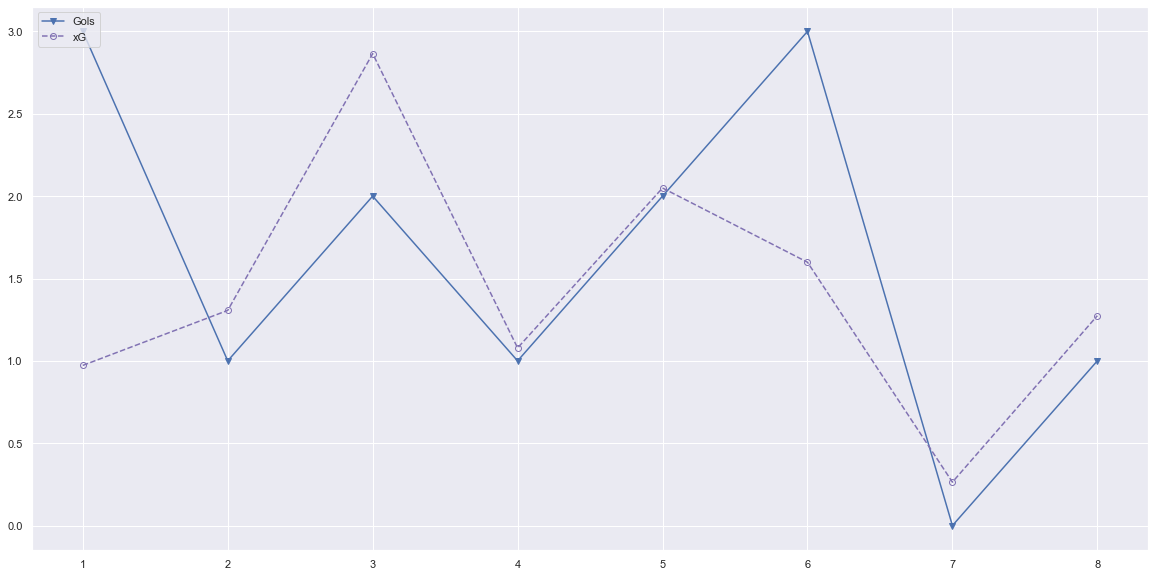

In [375]:
# xG_philosophy_clubes(df_brasileiro,clube=262,rodada=rodada)

# xA Atletas

#### Agora vamos fazer o cálculo de xG etc sob a perspectiva dos atletas

- Estudo 01. xA total
- Estudo 02. xA por jogo
- Estudo 03. xA vs gols
- Estudo 04. xA como medida de eficiência
- Estudo 05. xA como medida de potencial

## xA Total

In [70]:
df_atletas = df_brasileiro.groupby(['atleta_id', 'apelido','clube_id'])['xA'].sum().reset_index()
df_atletas = df_atletas.sort_values(by='xA',ascending=False).reset_index(drop=True)
df_atletas = df_atletas[df_atletas['clube_id'].isin(clubes_ids)].reset_index(drop=True)
df_atletas['clube'] = df_atletas['clube_id'].map(times_dict_r)
df_atletas['clube'] = df_atletas['clube'].map(team_icons)

df_atletas = df_atletas[['apelido','clube_id','clube','xA']]
df_atletas.head(30)

,apelido,clube_id,clube,xA
0,Cauly,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,3.676262
1,Arias,266,![Fluminense](https://s.glbimg.com/es/sde/f/or...,3.284058
2,Gerson,262,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,3.007926
3,Bitello,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,2.859389
4,Bruno Rodrigues,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,2.651251
5,Lucas Evangelista,280,![Bragantino](https://s.glbimg.com/es/sde/f/or...,2.629352
6,Thaciano,265,![Bahia](https://s.glbimg.com/es/sde/f/organiz...,2.526366
7,Luis Suárez,284,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,2.389463
8,Marlon,283,![Cruzeiro](https://s.sde.globo.com/media/orga...,2.301562
9,Caio Paulista,276,![São Paulo](https://s.glbimg.com/es/sde/f/org...,2.242424


## Adiconar métricas 

- xG_per_match
- xG_per_shot
- shots_per_goal

In [377]:
df_atletas2 = df_brasileiro.groupby(['atleta_id', 'apelido', 'clube_id']).agg(xG_total=('xG', 'sum'),
                                                                             shots_total=('Lance', 'count'),
                                                                             jogos_num=('rodada_id', 'nunique'),
                                                                             goals_total=('Goal', 'sum')).reset_index()
df_atletas2['xG_per_match']=df_atletas2['xG_total']/df_atletas2['jogos_num']
df_atletas2['G_per_match']=df_atletas2['goals_total']/df_atletas2['jogos_num']
df_atletas2['xG_per_shot'] = df_atletas2['xG_total']/df_atletas2['shots_total']
df_atletas2['shots_per_goal'] = df_atletas2['shots_total']/df_atletas2['goals_total']
df_atletas2['clube'] = df_atletas2['clube_id'].map(times_dict_r)
df_atletas2['clube'] = df_atletas2['clube'].map(team_icons)

xg_total = df_atletas2.sort_values(by='xG_total',ascending=False).reset_index(drop=True)

#df_atletas2 = df_atletas2[df_atletas2['clube_id'].isin(clubes_ids)].sort_values(by='xG_total',ascending=False).reset_index(drop=True)

xg_total.head(50)

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,83257,Gabriel,262,3.216875,23,7,3,0.459554,0.428571,0.139864,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
1,61188,Gilberto,283,2.801841,22,8,3,0.350230,0.375000,0.127356,7.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...
2,89898,Róger Guedes,264,2.724498,29,7,4,0.389214,0.571429,0.093948,7.250000,![Corinthians](https://s.glbimg.com/es/sde/f/o...
3,73850,Aloísio,327,2.677313,23,7,3,0.382473,0.428571,0.116405,7.666667,![América-MG](https://s.glbimg.com/es/sde/f/o...
4,87470,Thaciano,265,2.626094,30,6,2,0.437682,0.333333,0.087536,15.000000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
7,101002,Júnior Santos,263,2.459331,22,8,2,0.307416,0.250000,0.111788,11.000000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
8,39148,Hulk,282,2.398085,30,8,4,0.299761,0.500000,0.079936,7.500000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
9,92811,Bruno Rodrigues,283,2.199849,25,8,2,0.274981,0.250000,0.087994,12.500000,![Cruzeiro](https://s.sde.globo.com/media/orga...


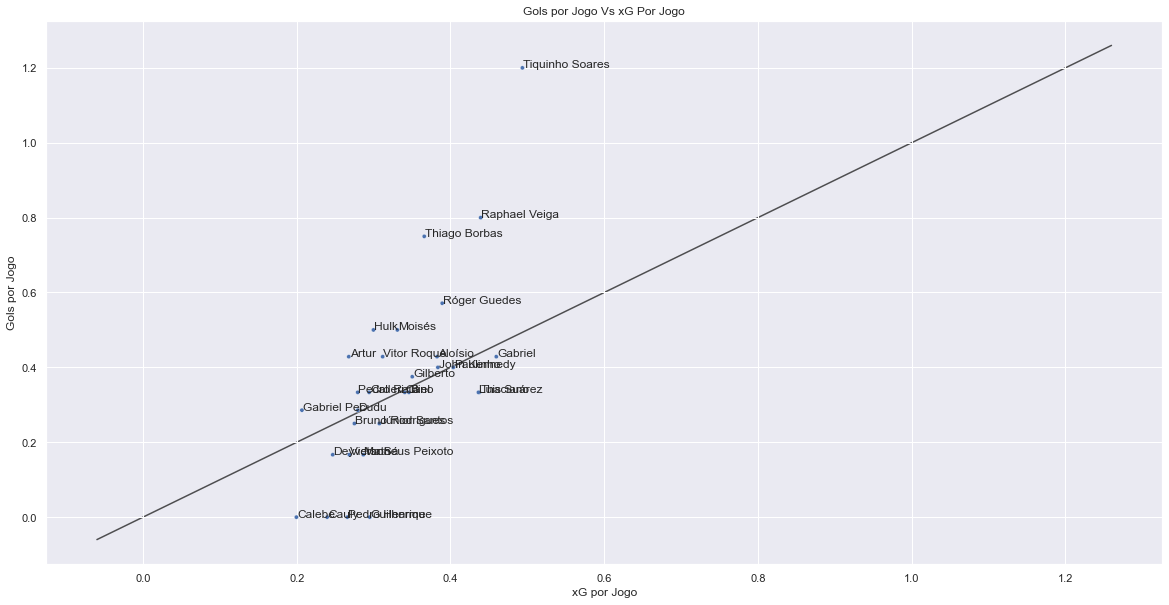

In [378]:
def xG_fit(df,rodada):
    # pegar apenas 30
    df = df.head(30)
    # # obter médias para o tracejado nos eixos
    # xG_geral_mean = np.mean(list(df['xG_geral'].values))
    # xGA_geral_mean = np.mean(list(df['xGA_geral'].values))
    
    #sns.set_theme()
    
    #plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))

    p1 = sns.scatterplot('xG_per_match', # Horizontal axis
       'G_per_match', # Vertical axis
       data=df, # Data source
       size = 8,
       legend=False) 
    
    
    plt.title('Gols por Jogo Vs xG Por Jogo')
    # Set x-axis label
    plt.xlabel('xG por Jogo')
    # Set y-axis label
    plt.ylabel('Gols por Jogo')
    
    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.001, point['y'], str(point['val']))
            #ax.plot([-1,1],[-1,1], 'red', linewidth=10)

            
    label_point(df.xG_per_match, df.G_per_match, df.apelido, plt.gca())  

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    #ax.set_aspect('equal')
    # ax.set_xlim(lims)
    # ax.set_ylim(lims)
    
    fig.savefig(f'img/G_vs_xG_fit_atletas{rodada}.png')
    
xG_fit(xg_total,rodada)

## xG per match

In [379]:
rodada = df_brasileiro['rodada_id'].max()
PORCENTAGEM_MINIMA_JOGOS = 2.5  # 40%
min_jogos = rodada // PORCENTAGEM_MINIMA_JOGOS
print(min_jogos)

mask = (xg_total['jogos_num']>=int(min_jogos))
xg_per_match = xg_total.loc[mask]
xg_per_match = xg_per_match.sort_values(by='xG_per_match',ascending=False).reset_index(drop=True)

xg_per_match.head(20)

3.0


,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube
0,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...
1,83257,Gabriel,262,3.216875,23,7,3,0.459554,0.428571,0.139864,7.666667,![Flamengo](https://s.glbimg.com/es/sde/f/orga...
2,93108,Mateus Vital,283,1.333061,12,3,0,0.444354,0.000000,0.111088,inf,![Cruzeiro](https://s.sde.globo.com/media/orga...
3,94509,Raphael Veiga,275,2.196487,23,5,4,0.439297,0.800000,0.095499,5.750000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...
4,87470,Thaciano,265,2.626094,30,6,2,0.437682,0.333333,0.087536,15.000000,![Bahia](https://s.glbimg.com/es/sde/f/organiz...
5,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...
6,124251,Deivid Washington,277,1.241499,12,3,2,0.413833,0.666667,0.103458,6.000000,![Santos](https://s.glbimg.com/es/sde/f/organi...
7,99818,Paulinho,282,2.018075,14,5,2,0.403615,0.400000,0.144148,7.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...
8,98022,Erick,293,1.192451,10,3,0,0.397484,0.000000,0.119245,inf,![Athlético-PR](https://s.glbimg.com/es/sde/f/...
9,89898,Róger Guedes,264,2.724498,29,7,4,0.389214,0.571429,0.093948,7.250000,![Corinthians](https://s.glbimg.com/es/sde/f/o...


In [380]:
xg_per_match = xg_per_match[['apelido','clube','xG_per_match','G_per_match']]
xg_per_match.head(20).to_csv(f'conteudo/xG_ate_R{rodada}.csv', index=False)



## xG vs Gols

Um estudo comparativo entre Gols e Expected Gols pode ser visto sob dois prismas:

- Eficiência
- Potencial

### 'Eficiência' mede, a partir da diferença entre uma métrica e outra, o nível de aproveitamento dos atletas.

In [381]:
df_atletas2['eficiência'] = df_atletas2['goals_total']-df_atletas2['xG_total']
df_eficiencia = df_atletas2.loc[df_atletas2['goals_total']>=1].sort_values(by='eficiência',ascending=False).reset_index(drop=True).head(50)
df_eficiencia.dropna()

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,84042,Tiquinho Soares,263,2.467826,21,5,6,0.493565,1.200000,0.117516,3.500000,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,3.532174
1,84817,Robson,294,0.585521,5,4,3,0.146380,0.750000,0.117104,1.666667,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,2.414479
2,94509,Raphael Veiga,275,2.196487,23,5,4,0.439297,0.800000,0.095499,5.750000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.803513
3,115959,Endrick,275,1.197232,9,5,3,0.239446,0.600000,0.133026,3.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.802768
4,70360,Eduardo Sasha,280,1.276931,10,7,3,0.182419,0.428571,0.127693,3.333333,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.723069
5,91706,Marlon,283,0.291919,3,2,2,0.145959,1.000000,0.097306,1.500000,![Cruzeiro](https://s.sde.globo.com/media/orga...,1.708081
6,113359,Pablo Maia,276,0.394424,9,6,2,0.065737,0.333333,0.043825,4.500000,![São Paulo](https://s.glbimg.com/es/sde/f/org...,1.605576
7,39148,Hulk,282,2.398085,30,8,4,0.299761,0.500000,0.079936,7.500000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,1.601915
8,83528,Léo Pereira,262,0.451552,4,3,2,0.150517,0.666667,0.112888,2.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,1.548448
9,117314,Thiago Borbas,280,1.463322,8,4,3,0.365831,0.750000,0.182915,2.666667,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.536678


In [382]:
df_eficiencia = df_eficiencia[['apelido','clube','xG_total','goals_total','xG_per_match','G_per_match','shots_per_goal']]
df_eficiencia.head(20).to_csv(f'conteudo/Eficiencia_ate_R{rodada}.csv', index=False)
df_eficiencia

,apelido,clube,xG_total,goals_total,xG_per_match,G_per_match,shots_per_goal
0,Tiquinho Soares,![Botafogo](https://s.glbimg.com/es/sde/f/equi...,2.467826,6,0.493565,1.200000,3.500000
1,Robson,![Coritiba](https://s.glbimg.com/es/sde/f/orga...,0.585521,3,0.146380,0.750000,1.666667
2,Raphael Veiga,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,2.196487,4,0.439297,0.800000,5.750000
3,Endrick,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,1.197232,3,0.239446,0.600000,3.000000
4,Eduardo Sasha,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.276931,3,0.182419,0.428571,3.333333
5,Marlon,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.291919,2,0.145959,1.000000,1.500000
6,Pablo Maia,![São Paulo](https://s.glbimg.com/es/sde/f/org...,0.394424,2,0.065737,0.333333,4.500000
7,Hulk,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,2.398085,4,0.299761,0.500000,7.500000
8,Léo Pereira,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.451552,2,0.150517,0.666667,2.000000
9,Thiago Borbas,![Bragantino](https://s.glbimg.com/es/sde/f/or...,1.463322,3,0.365831,0.750000,2.666667


### 'Potencial' mede, por outro lado, aqueles atletas que tem maior potencial de crescimento
Se invertermos o ranking, vemos quem está no topo do aproveitamente abaixo do esperado, ou seja, com maiores possibilidades de convergência para a expectativa

In [383]:
# note: ascending = True
df_potencial = df_atletas2.loc[df_atletas2['goals_total']>=1].head(20).sort_values(by='eficiência',ascending=True).reset_index(drop=True)
df_potencial

,atleta_id,apelido,clube_id,xG_total,shots_total,jogos_num,goals_total,xG_per_match,G_per_match,xG_per_shot,shots_per_goal,clube,eficiência
0,69318,Luis Suárez,284,2.618237,21,6,2,0.436373,0.333333,0.124678,10.500000,![Grêmio](https://s.glbimg.com/es/sde/f/organi...,-0.618237
1,69138,Pablo,293,1.005802,16,7,1,0.143686,0.142857,0.062863,16.000000,![Athlético-PR](https://s.glbimg.com/es/sde/f/...,-0.005802
2,68920,Dudu,275,1.956005,22,7,2,0.279429,0.285714,0.088909,11.000000,![Palmeiras](https://s.glbimg.com/es/sde/f/org...,0.043995
3,61188,Gilberto,283,2.801841,22,8,3,0.350230,0.375000,0.127356,7.333333,![Cruzeiro](https://s.sde.globo.com/media/orga...,0.198159
4,73850,Aloísio,327,2.677313,23,7,3,0.382473,0.428571,0.116405,7.666667,![América-MG](https://s.glbimg.com/es/sde/f/o...,0.322687
5,69102,Vargas,282,0.510632,4,2,1,0.255316,0.500000,0.127658,4.000000,![Atlético-MG](https://s.glbimg.com/es/sde/f/o...,0.489368
6,52827,David Luiz,262,0.362464,4,3,1,0.120821,0.333333,0.090616,4.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.637536
7,70666,Marllon,1371,0.327906,4,3,1,0.109302,0.333333,0.081977,4.000000,![Cuiabá](https://s.glbimg.com/es/sde/f/organ...,0.672094
8,51042,Apodi,290,0.278492,3,2,1,0.139246,0.500000,0.092831,3.000000,![Goiás](https://s.glbimg.com/es/sde/f/organiz...,0.721508
9,51772,Everton Ribeiro,262,0.277240,5,3,1,0.092413,0.333333,0.055448,5.000000,![Flamengo](https://s.glbimg.com/es/sde/f/orga...,0.722760


In [210]:
df_brasileiro.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1096 entries, 2257681 to 2304742
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Codigo         1096 non-null   int64  
 1   Lance          1096 non-null   object 
 2   Nome           1096 non-null   object 
 3   Ocorrencia     1096 non-null   object 
 4   PosicaoLance   1096 non-null   int64  
 5   TempoPartida   1096 non-null   int64  
 6   TimestampStr   1096 non-null   object 
 7   atleta_id      1096 non-null   int64  
 8   apelido        1096 non-null   object 
 9   sigla          1096 non-null   object 
 10  posicao_id     1096 non-null   int64  
 11  match_id       1096 non-null   float64
 12  tempo          1096 non-null   object 
 13  tempo_2        1096 non-null   object 
 14  clube_id       1096 non-null   int64  
 15  Codigo_SCT     1096 non-null   float64
 16  match_id_sct   1096 non-null   float64
 17  rodada_id      1096 non-null   int64  
 18 

In [ ]:
# def xG_geral(df, row):
#     # Geral
#     conquistado_geral = df[(df['rodada_id']<=row['rodada_id']) & \
#                            (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_geral[0]

# def xG_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     conquistado_mandante_posicao = df[(df['home_dummy']==1) & \
#                                       (df['clube_id']==row['clube_id']) & \
#                                       (df['rodada_id']<=row['rodada_id']) & \
#                                       (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_mandante_geral = df[(df['home_dummy']==1) & \
#                                     (df['rodada_id']<=row['rodada_id']) & \
#                                     (df['clube_id']==row['clube_id'])][['xG']].mean()
#     # Visitante
#     # Posicao
#     conquistado_visitante_posicao = df[(df['home_dummy']==0) & \
#                                        (df['clube_id']==row['clube_id']) & \
#                                        (df['rodada_id']<=row['rodada_id']) & \
#                                        (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     conquistado_visitante_geral = df[(df['home_dummy']==0) & \
#                                      (df['rodada_id']<=row['rodada_id']) & \
#                                      (df['clube_id']==row['clube_id'])][['xG']].mean()

#     return conquistado_mandante_posicao[0], conquistado_mandante_geral[0], conquistado_visitante_posicao[0], conquistado_visitante_geral[0]

# # xG allowed
# def xGA_mando_posicao(df, row):
#     # Mandante
#     # Posicao
#     cedido_mandante_posicao = df[(df['home_dummy']==0) & \
#                                  (df['adversario_id']==row['equipe_id']) & \
#                                  (df['rodada_id']<=row['rodada_id']) & \
#                                  (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_mandante_geral = df[(df['home_dummy']==0) & \
#                                (df['rodada_id']<=row['rodada_id']) & \
#                                (df['adversario_id']==row['equipe_id'])][['xG']].mean()

#     # Visitante
#     # Posicao
#     cedido_visitante_posicao = df[(df['home_dummy']==1) & \
#                                   (df['adversario_id']==row['equipe_id']) & \
#                                   (df['rodada_id']<=row['rodada_id']) & \
#                                   (df['posicao_id']==row['posicao_id'])][['xG']].mean()
#     # Geral
#     cedido_visitante_geral = df[(df['home_dummy']==1) & \
#                                 (df['rodada_id']<=row['rodada_id']) & \
#                                 (df['adversario_id']==row['equipe_id'])][['xG']].mean()


#     return cedido_mandante_posicao[0], cedido_mandante_geral[0], cedido_visitante_posicao[0], cedido_visitante_geral[0]

# df_brasileiro['xg_mando_pos'] = df_brasileiro.apply(lambda x: xG_mando_posicao(df_brasileiro, x))
# #print (df_brasileiro.query('rodada_id >= 1')[('sum', 'xG')].mean())